# 12th Oct

In [6]:
    import os
    import cv2
    import pydicom
    import pandas as pd
    import numpy as np 
    import matplotlib.pyplot as plt 
    import random
    from tqdm import tqdm 
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    import torchvision.models as models
    from PIL import Image
    import json
    from pathlib import Path
    import joblib
    import warnings
    import pickle
    from typing import Dict, List, Tuple, Optional
    from scipy import ndimage
    from scipy.ndimage import binary_fill_holes, generate_binary_structure
    from skimage import measure, morphology
    from skimage.transform import resize
    import albumentations as albu
    from albumentations.pytorch import ToTensorV2

    warnings.filterwarnings('ignore')

    def seed_everything(seed=42):
        """Ensure reproducibility across all random operations"""
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
    seed_everything(42)

    # Configuration
    DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
    TRAIN_DIR = DATA_DIR / "train"
    TEST_DIR = DATA_DIR / "test"

    # GPU Configuration for P100
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Enable optimizations for GPU training
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # Auto-tune for best performance on P100
        torch.cuda.empty_cache()  # Clear cache before starting

    print("🚀 Fixed OSIC Model - Complete Working Version")
    print("=" * 60)
    print(f"📱 Device: {DEVICE}")
    if torch.cuda.is_available():
        print(f"🔥 GPU: {torch.cuda.get_device_name()}")
        print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"⚡ CUDA Version: {torch.version.cuda}")
        print(f"🚀 cuDNN Benchmark: Enabled (P100 optimized)")
    print("=" * 60)

    # Load Data
    train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
    print(f"Loaded dataset with shape: {train_df.shape}")

    def get_tab_features(df_row):
        """Extract tabular features (returns 4 features)"""
        vector = [(df_row['Age'] - 30) / 30] 
        
        # Sex encoding
        if df_row['Sex'] == 'Male':
            vector.append(0)
        else:
            vector.append(1)
        
        # Smoking status encoding
        smoking_status = df_row['SmokingStatus']
        if smoking_status == 'Never smoked':
            vector.extend([0, 0])
        elif smoking_status == 'Ex-smoker':
            vector.extend([1, 1])
        elif smoking_status == 'Currently smokes':
            vector.extend([0, 1])
        else:
            vector.extend([1, 0])
        return np.array(vector)

    # 🔄 NEW APPROACH: Visit-level FVC prediction
    # Instead of predicting one slope per patient, predict actual FVC at each visit
    print("=" * 60)
    print("📊 Creating Visit-Level Dataset")
    print("=" * 60)

    visit_data = []
    patient_baselines = {}

    # First pass: collect baseline information for each patient
    for patient in train_df['Patient'].unique():
        sub = train_df[train_df['Patient'] == patient].copy().sort_values('Weeks')
        if len(sub) > 0:
            # Get baseline (first measurement)
            baseline_fvc = sub.iloc[0]['FVC']
            baseline_percent = sub.iloc[0]['Percent']
            baseline_week = sub.iloc[0]['Weeks']
            
            patient_baselines[patient] = {
                'baseline_fvc': baseline_fvc,
                'baseline_percent': baseline_percent,
                'baseline_week': baseline_week,
                'tabular': get_tab_features(sub.iloc[0])
            }

    # Second pass: create visit-level samples
    print("Creating visit-level samples...")
    for patient in tqdm(train_df['Patient'].unique()):
        sub = train_df[train_df['Patient'] == patient].copy().sort_values('Weeks')
        
        if patient not in patient_baselines:
            continue
        
        baseline_info = patient_baselines[patient]
        
        # Create one sample for each visit
        for idx, row in sub.iterrows():
            visit_data.append({
                'Patient': patient,
                'Week': row['Weeks'],
                'FVC': row['FVC'],  # Target: actual FVC at this visit
                'Percent': row['Percent'],
                'Age': row['Age'],
                'Sex': row['Sex'],
                'SmokingStatus': row['SmokingStatus'],
                
                # Temporal features (NEW!)
                'WeeksFromBaseline': row['Weeks'] - baseline_info['baseline_week'],
                'BaselineFVC': baseline_info['baseline_fvc'],
                'BaselinePercent': baseline_info['baseline_percent'],
                
                # Tabular features
                'tabular_features': baseline_info['tabular']
            })

    visit_df = pd.DataFrame(visit_data)

    print(f"\n✅ Dataset created:")
    print(f"   Total visits: {len(visit_df)}")
    print(f"   Unique patients: {visit_df['Patient'].nunique()}")
    print(f"   Avg visits per patient: {len(visit_df) / visit_df['Patient'].nunique():.1f}")
    print(f"   FVC range: [{visit_df['FVC'].min():.0f}, {visit_df['FVC'].max():.0f}] mL")
    print(f"   Weeks range: [{visit_df['WeeksFromBaseline'].min():.0f}, {visit_df['WeeksFromBaseline'].max():.0f}]")

    class MedicalAugmentation:
        def __init__(self, augment=True):
            if augment:
                self.transform = albu.Compose([
                    albu.Rotate(limit=15, p=0.7),
                    albu.HorizontalFlip(p=0.5),
                    albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
                    albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
                    albu.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                    albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
                    albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
                    albu.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=0.3),
                    albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
                    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
            else:
                self.transform = albu.Compose([
                    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
        
        def __call__(self, image):
            return self.transform(image=image)['image']

    class SpatialAttention(nn.Module):
        def __init__(self, kernel_size=7):
            super(SpatialAttention, self).__init__()
            self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            avg_out = torch.mean(x, dim=1, keepdim=True)
            max_out, _ = torch.max(x, dim=1, keepdim=True)
            x_cat = torch.cat([avg_out, max_out], dim=1)
            x_cat = self.conv1(x_cat)
            return x * self.sigmoid(x_cat)

    class WorkingDenseNetModel(nn.Module):
        """
        🔄 UPDATED: Now predicts absolute FVC values (not slopes)
        
        Input:
        - CT scan: 3 x 512 x 512
        - Tabular: 7 features (Age, Sex, Smoking, WeeksFromBaseline, BaselineFVC, BaselinePercent)
        
        Output:
        - FVC prediction (mL)
        - Uncertainty (log variance)
        """
        
        def __init__(self, tabular_dim=7, dropout_rate=0.4):  # Changed from 4 to 7
            super(WorkingDenseNetModel, self).__init__()
            
            # DenseNet121 backbone
            densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
            self.features = densenet.features
            
            # Spatial attention
            self.spatial_attention = SpatialAttention()
            
            # Enhanced tabular processing
            self.tabular_processor = nn.Sequential(
                nn.Linear(tabular_dim, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 512),
                nn.BatchNorm1d(512),
                nn.ReLU()
            )
            
            # Cross-modal attention
            self.cross_attention = nn.MultiheadAttention(
                embed_dim=1024, num_heads=8, dropout=0.2, batch_first=True
            )
            
            # Initialize projection weight properly
            self.tab_projection = nn.Linear(512, 1024)
            
            # Multi-modal fusion
            self.fusion_layer = nn.Sequential(
                nn.Linear(1024 + 512, 768),
                nn.BatchNorm1d(768),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(768, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate/2)
            )
            
            # Uncertainty quantification heads
            self.mean_head = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
            
            self.log_var_head = nn.Sequential(
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 1)
            )
            
        def forward(self, images, tabular):
            batch_size = images.size(0)
            
            # Extract image features
            img_features = self.features(images)
            
            # Apply spatial attention
            img_features = self.spatial_attention(img_features)
            
            # Global average pooling
            img_features = F.adaptive_avg_pool2d(img_features, (1, 1))
            img_features = img_features.view(batch_size, -1)
            
            # Process tabular data
            tab_features = self.tabular_processor(tabular)
            
            # Cross-modal attention
            img_expanded = img_features.unsqueeze(1)
            tab_expanded = tab_features.unsqueeze(1)
            
            # Project tabular to same dimension for attention
            tab_proj = self.tab_projection(tab_expanded)
            
            attended_img, _ = self.cross_attention(
                img_expanded, tab_proj, tab_proj
            )
            attended_img = attended_img.squeeze(1)
            
            # Fusion
            combined_features = torch.cat([attended_img, tab_features], dim=1)
            fused_features = self.fusion_layer(combined_features)
            
            # Predict mean and log variance
            mean_pred = self.mean_head(fused_features)
            log_var = self.log_var_head(fused_features)
            
            return mean_pred.squeeze(), log_var.squeeze()

    class OSICVisitLevelDataset(Dataset):
        """
        🔄 NEW: Visit-level dataset for FVC prediction
        
        Each sample represents ONE visit (patient at specific timepoint):
        - Input: CT scan + tabular + temporal features
        - Target: FVC value at that visit
        """
        
        def __init__(self, visit_dataframe, data_dir, split='train', augment=True):
            self.visit_df = visit_dataframe.reset_index(drop=True)
            self.data_dir = Path(data_dir)
            self.split = split
            self.augment = augment
            self.augmentor = MedicalAugmentation(augment=augment)
            
            # Filter out problematic patients
            problematic = ['ID00011637202177653955184', 'ID00052637202186188008618']
            self.visit_df = self.visit_df[~self.visit_df['Patient'].isin(problematic)]
            
            # Prepare image paths for each patient (one CT per patient, used for all visits)
            # 🔄 IMPROVEMENT: Store ALL slices, will select based on visit context
            self.patient_images = {}
            for patient in self.visit_df['Patient'].unique():
                patient_dir = self.data_dir / patient
                if patient_dir.exists():
                    image_files = sorted([f for f in patient_dir.iterdir() if f.suffix.lower() == '.dcm'])
                    if image_files:
                        # Store ALL slices instead of just middle one
                        self.patient_images[patient] = image_files
            
            # Filter visits with available images
            self.visit_df = self.visit_df[self.visit_df['Patient'].isin(self.patient_images.keys())]
            
            print(f"Dataset {split}: {len(self.visit_df)} visits from {self.visit_df['Patient'].nunique()} patients")
        
        def __len__(self):
            return len(self.visit_df)
        
        def __getitem__(self, idx):
            row = self.visit_df.iloc[idx]
            patient = row['Patient']
            
            # 🔄 IMPROVED: Select slice based on temporal context
            # Later visits might show more severe disease → use different slices
            image_files = self.patient_images[patient]
            
            if self.augment:
                # Training: Add variety by randomly selecting from middle 60% of slices
                start_idx = len(image_files) // 5
                end_idx = len(image_files) * 4 // 5
                selected_image = image_files[np.random.randint(start_idx, max(start_idx + 1, end_idx))]
            else:
                # Validation: Use consistent middle slice
                selected_image = image_files[len(image_files) // 2]
            
            # Load and preprocess image
            img = self.load_and_preprocess_dicom(selected_image)
            
            # Apply augmentations
            img_tensor = self.augmentor(img)
            
            # 🔄 NEW: Enhanced tabular features with temporal information
            tab_features = np.concatenate([
                row['tabular_features'],  # Age, Sex, Smoking (4 features)
                [(row['WeeksFromBaseline'] + 12) / 52],  # Normalized weeks (1 feature)
                [row['BaselineFVC'] / 1000],  # Normalized baseline FVC (1 feature)
                [row['BaselinePercent'] / 100]  # Baseline FVC % (1 feature)
            ])  # Total: 7 features (was 4)
            
            tab_features = torch.tensor(tab_features, dtype=torch.float32)
            
            # 🎯 NEW TARGET: Actual FVC value (not slope)
            target_fvc = torch.tensor(row['FVC'], dtype=torch.float32)
            
            return img_tensor, tab_features, target_fvc, patient
        
        def load_and_preprocess_dicom(self, path):
            """Enhanced DICOM loading with better preprocessing"""
            try:
                # Load DICOM
                dcm = pydicom.dcmread(str(path))
                img = dcm.pixel_array.astype(np.float32)
                
                # Handle different DICOM formats
                if len(img.shape) == 3:
                    img = img[img.shape[0]//2]
                
                # Resize to target size
                img = cv2.resize(img, (512, 512))
                
                # Normalize to 0-255 range
                img_min, img_max = img.min(), img.max()
                if img_max > img_min:
                    img = (img - img_min) / (img_max - img_min) * 255
                else:
                    img = np.zeros_like(img)
                
                # Convert to 3-channel
                img = np.stack([img, img, img], axis=2).astype(np.uint8)
                
                return img
                
            except Exception as e:
                print(f"Error loading DICOM {path}: {e}")
                return np.zeros((512, 512, 3), dtype=np.uint8)

    class SimpleTrainer:
        """
        Simple trainer that works with any model structure
        
        🎯 RESEARCH PAPER CONFIGURATION:
        - Primary metric: MAE (Mean Absolute Error) - standard for regression papers
        - Secondary metric: Laplace LL (Log Likelihood) - for competitive comparison
        - Model saving: Best MAE (recommended for publication)
        
        📊 TO TOGGLE TRAINING LOSS:
        Set use_laplace_loss=True to train with Laplace LL instead of uncertainty loss
        """
        
        def __init__(self, model, device, lr=1e-4, use_laplace_loss=False):
            self.model = model
            self.device = device
            self.lr = lr
            self.use_laplace_loss = use_laplace_loss  # 🎯 Toggle between MAE and LLL training
            self.best_val_mae = float('inf')
            self.best_laplace_ll = float('-inf')
            
            print(f"\n{'='*60}")
            print(f"🎯 TRAINER CONFIGURATION")
            print(f"{'='*60}")
            print(f"Training Loss: {'Laplace Log Likelihood' if use_laplace_loss else 'Uncertainty Loss (MAE-based)'}")
            print(f"Model Saving: Best MAE (Research Paper Standard)")
            print(f"Monitoring: MAE, RMSE, R², Correlation, Laplace LL")
            print(f"{'='*60}\n")
            
        def uncertainty_loss(self, mean_pred, log_var, targets, reduction='mean'):
            """Uncertainty-aware loss function"""
            var = torch.exp(log_var)
            mse_loss = (mean_pred - targets) ** 2
            loss = 0.5 * (mse_loss / var + log_var)
            
            if reduction == 'mean':
                return loss.mean()
            return loss.sum()
        
        def laplace_log_likelihood(self, mean_pred, log_var, targets, return_tensor=False):
            """
            Calculate Laplace Log Likelihood (OSIC competition metric)
            
            🎯 DUAL USE:
            - Monitoring: return_tensor=False (default) → returns scalar for logging
            - Training: return_tensor=True → returns tensor for backprop
            
            Higher is better (closer to 0 from negative)
            
            Formula: -√2 * |pred - actual| / σ - log(√2 * σ)
            where σ = sqrt(exp(log_var)), clipped to minimum 70
            
            Competition Rule: Minimum σ = 70mL (cannot be more confident than ±70mL)
            """
            sigma = torch.sqrt(torch.exp(log_var))
            sigma_clipped = torch.clamp(sigma, min=70)  # Competition rule: min confidence = 70
            
            delta = torch.abs(mean_pred - targets)
            
            # Laplace log likelihood
            ll = -np.sqrt(2) * delta / sigma_clipped - torch.log(np.sqrt(2) * sigma_clipped)
            
            if return_tensor:
                return ll.mean()  # Return tensor for backprop
            else:
                return ll.mean().item()  # Return scalar for logging
        
        def calculate_r2_score(self, predictions, targets):
            """Calculate R² score"""
            predictions = np.array(predictions)
            targets = np.array(targets)
            ss_res = np.sum((targets - predictions) ** 2)
            ss_tot = np.sum((targets - np.mean(targets)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            return r2
            
        def train(self, train_loader, val_loader, epochs=30, patience=8):
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=4, verbose=True
            )
            
            # Mixed precision training for P100 speedup
            scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
            use_amp = torch.cuda.is_available()
            
            if use_amp:
                print("⚡ Mixed Precision Training ENABLED for P100")
            
            patience_counter = 0
            
            for epoch in range(epochs):
                # Training phase
                self.model.train()
                train_loss = 0.0
                train_mae = 0.0
                train_batches = 0
                
                for batch_idx, (images, tabular, targets, _) in enumerate(train_loader):
                    try:
                        images = images.to(self.device)
                        tabular = tabular.to(self.device) 
                        targets = targets.to(self.device)
                        
                        optimizer.zero_grad()
                        
                        # Mixed precision forward pass
                        if use_amp:
                            with torch.cuda.amp.autocast():
                                mean_pred, log_var = self.model(images, tabular)
                                
                                # 🎯 AUTOMATIC LOSS SELECTION based on initialization flag
                                if self.use_laplace_loss:
                                    # Option A: Train with Laplace LL (competition metric)
                                    loss = -self.laplace_log_likelihood(mean_pred, log_var, targets, return_tensor=True)
                                else:
                                    # Option B: Train with Uncertainty Loss (MAE-based, research standard)
                                    loss = self.uncertainty_loss(mean_pred, log_var, targets)
                                
                                mae = F.l1_loss(mean_pred, targets)
                        else:
                            mean_pred, log_var = self.model(images, tabular)
                            
                            # 🎯 AUTOMATIC LOSS SELECTION based on initialization flag
                            if self.use_laplace_loss:
                                # Option A: Train with Laplace LL (competition metric)
                                loss = -self.laplace_log_likelihood(mean_pred, log_var, targets, return_tensor=True)
                            else:
                                # Option B: Train with Uncertainty Loss (MAE-based, research standard)
                                loss = self.uncertainty_loss(mean_pred, log_var, targets)
                            
                            mae = F.l1_loss(mean_pred, targets)
                        
                        # Mixed precision backward pass
                        if use_amp:
                            scaler.scale(loss).backward()
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                            optimizer.step()
                        
                        train_loss += loss.item()
                        train_mae += mae.item()
                        train_batches += 1
                        
                    except Exception as e:
                        print(f"Error in training batch {batch_idx}: {e}")
                        continue
                
                # Validation phase
                self.model.eval()
                val_loss = 0.0
                val_mae = 0.0
                val_predictions = []
                val_targets = []
                
                with torch.no_grad():
                    for batch_idx, (images, tabular, targets, _) in enumerate(val_loader):
                        try:
                            images = images.to(self.device)
                            tabular = tabular.to(self.device)
                            targets = targets.to(self.device)
                            
                            mean_pred, log_var = self.model(images, tabular)
                            
                            loss = self.uncertainty_loss(mean_pred, log_var, targets)
                            mae = F.l1_loss(mean_pred, targets)
                            
                            val_loss += loss.item()
                            val_mae += mae.item()
                            
                            val_predictions.extend(mean_pred.cpu().numpy())
                            val_targets.extend(targets.cpu().numpy())
                            
                        except Exception as e:
                            print(f"Error in validation batch {batch_idx}: {e}")
                            continue
                
                # Calculate metrics
                if train_batches > 0 and len(val_predictions) > 0:
                    avg_train_loss = train_loss / train_batches
                    avg_train_mae = train_mae / train_batches
                    avg_val_loss = val_loss / len(val_loader)
                    avg_val_mae = val_mae / len(val_loader)
                    
                    # Calculate R² score
                    train_r2 = self.calculate_r2_score(
                        [p.item() for p in self.model(images, tabular)[0][-8:]] if train_batches > 0 else [],
                        [t.item() for t in targets[-8:]] if train_batches > 0 else []
                    ) if train_batches > 0 else 0
                    
                    val_r2 = self.calculate_r2_score(val_predictions, val_targets)
                    
                    # Calculate Laplace Log Likelihood for validation
                    val_laplace_ll = 0.0
                    with torch.no_grad():
                        for batch_idx, (images, tabular, targets, _) in enumerate(val_loader):
                            images = images.to(self.device)
                            tabular = tabular.to(self.device)
                            targets = targets.to(self.device)
                            mean_pred, log_var = self.model(images, tabular)
                            val_laplace_ll += self.laplace_log_likelihood(mean_pred, log_var, targets)
                    
                    avg_val_laplace = val_laplace_ll / len(val_loader)
                    
                    # Calculate correlation
                    val_corr = np.corrcoef(val_predictions, val_targets)[0, 1] if len(val_predictions) > 1 else 0
                    
                    print(f"Epoch {epoch+1}/{epochs}")
                    print(f"Train - Loss: {avg_train_loss:.6f} | MAE: {avg_train_mae:.1f} mL")
                    print(f"Val   - Loss: {avg_val_loss:.6f} | MAE: {avg_val_mae:.1f} mL")
                    print(f"Val   - R²: {val_r2:.4f} | Correlation: {val_corr:.4f}")
                    print(f"Val   - Laplace LL: {avg_val_laplace:.6f}")
                    print(f"Val   - RMSE: {np.sqrt(mean_squared_error(val_targets, val_predictions)):.1f} mL")
                    
                    # Learning rate scheduling
                    scheduler.step(avg_val_mae)
                    
                    # 🎯 RESEARCH PAPER APPROACH: Save based on MAE (primary metric)
                    # Also track Laplace LL for competitive comparison
                    
                    improved = False
                    
                    # Primary: Save best MAE model (research paper standard)
                    if avg_val_mae < self.best_val_mae:
                        self.best_val_mae = avg_val_mae
                        torch.save(self.model.state_dict(), 'best_working_model_mae.pth')
                        print(f"✅ NEW BEST MAE! Model saved: {avg_val_mae:.1f} mL (Laplace LL: {avg_val_laplace:.4f})")
                        improved = True
                        patience_counter = 0
                    
                    # Secondary: Also save best Laplace LL model (for comparison)
                    if avg_val_laplace > self.best_laplace_ll:
                        self.best_laplace_ll = avg_val_laplace
                        torch.save(self.model.state_dict(), 'best_working_model_laplace.pth')
                        print(f"💾 Best Laplace LL model saved: {avg_val_laplace:.4f} (MAE: {avg_val_mae:.1f} mL)")
                        if not improved:
                            patience_counter = 0
                    
                    if not improved and avg_val_laplace <= self.best_laplace_ll:
                        patience_counter += 1
                        
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
                        
                    print("-" * 60)
            
            print(f"\n🏆 Training Summary:")
            print(f"   Best Validation MAE: {self.best_val_mae:.6f}")
            print(f"   Best Laplace Log Likelihood: {self.best_laplace_ll:.6f}")
            
            return self.best_val_mae, self.best_laplace_ll

    # Main execution
    def main():
        print("🔄 Creating data loaders...")
        print("=" * 60)
        
        # 🎯 PATIENT-LEVEL SPLIT (prevents data leakage!)
        # All visits from same patient stay together
        unique_patients = visit_df['Patient'].unique()
        train_patients, val_patients = train_test_split(
            unique_patients, 
            test_size=0.2, 
            random_state=42,
            shuffle=True
        )
        
        # Split visits by patient
        train_visits = visit_df[visit_df['Patient'].isin(train_patients)]
        val_visits = visit_df[visit_df['Patient'].isin(val_patients)]
        
        print(f"📊 Data Split:")
        print(f"   Train: {len(train_patients)} patients, {len(train_visits)} visits")
        print(f"   Val:   {len(val_patients)} patients, {len(val_visits)} visits")
        print(f"   Train FVC: {train_visits['FVC'].mean():.0f} ± {train_visits['FVC'].std():.0f} mL")
        print(f"   Val FVC:   {val_visits['FVC'].mean():.0f} ± {val_visits['FVC'].std():.0f} mL")
        print("=" * 60)
        
        # Create datasets
        train_dataset = OSICVisitLevelDataset(
            visit_dataframe=train_visits,
            data_dir=TRAIN_DIR,
            split='train',
            augment=True
        )
        
        val_dataset = OSICVisitLevelDataset(
            visit_dataframe=val_visits,
            data_dir=TRAIN_DIR,
            split='val',
            augment=False
        )
        
        # Create data loaders optimized for P100
        # P100 has 16GB memory - can handle larger batches
        batch_size = 16 if torch.cuda.is_available() else 8
        num_workers = 4 if torch.cuda.is_available() else 2  # P100 benefits from more workers
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True if torch.cuda.is_available() else False,
            drop_last=True,
            persistent_workers=True if num_workers > 0 else False  # Keep workers alive
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True if torch.cuda.is_available() else False,
            drop_last=False,
            persistent_workers=True if num_workers > 0 else False
        )
        
        print(f"✅ Data loaders created!")
        print(f"   Batch size: {batch_size} (P100 optimized)")
        print(f"   Train batches: {len(train_loader)}")
        print(f"   Val batches: {len(val_loader)}")
        print(f"   Workers: {num_workers}")
        
        # Initialize model
        print("🔄 Initializing model...")
        model = WorkingDenseNetModel(tabular_dim=7).to(DEVICE)  # 7 features now
        print(f"✅ Model initialized!")
        print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"📊 Output: FVC value (mL) + uncertainty")
        
        # Test model with actual batch
        try:
            test_batch = next(iter(train_loader))
            images, tabular, targets, _ = test_batch
            images = images.to(DEVICE)
            tabular = tabular.to(DEVICE)
            
            print(f"🔍 Testing model...")
            with torch.no_grad():
                mean_pred, log_var = model(images, tabular)
                print(f"✅ Model forward pass successful!")
                
        except Exception as e:
            print(f"❌ Model test failed: {e}")
            return
        
        # 🎯 TRAINING CONFIGURATION
        # Toggle between MAE-based (uncertainty_loss) and LLL-based training
        
        # ============================================================
        # 📊 OPTION 1: MAE-Based Training (RECOMMENDED FOR PAPERS)
        # ============================================================
        USE_LAPLACE_LOSS = False  # ← Set to True to train with Laplace LL instead
        
        print("\n" + "="*60)
        print("🎯 TRAINING CONFIGURATION FOR RESEARCH PAPER")
        print("="*60)
        print(f"Training Loss: {'Laplace Log Likelihood' if USE_LAPLACE_LOSS else 'Uncertainty Loss (MAE-based)'}")
        print(f"Model Saving: Best MAE (primary) + Best Laplace LL (secondary)")
        print(f"Monitoring: All metrics (MAE, RMSE, R², Correlation, Laplace LL)")
        print("="*60 + "\n")
        
        # Create trainer and start training
        print("🚀 Starting training...")
        trainer = SimpleTrainer(model, DEVICE, lr=1e-4, use_laplace_loss=USE_LAPLACE_LOSS)
        
        best_val_mae, best_laplace_ll = trainer.train(
            train_loader, 
            val_loader, 
            epochs=30,
            patience=8
        )
        
        print(f"\n🎯 Training completed!")
        print(f"   Best MAE: {best_val_mae:.6f}")
        print(f"   Best Laplace LL: {best_laplace_ll:.6f}")
        
        return model, train_loader, val_loader, best_val_mae, best_laplace_ll

    if __name__ == "__main__":
        model, train_loader, val_loader, best_val_mae, best_laplace_ll = main()

🚀 Fixed OSIC Model - Complete Working Version
📱 Device: cuda
🔥 GPU: Tesla P100-PCIE-16GB
💾 Memory: 17.1 GB
⚡ CUDA Version: 12.4
🚀 cuDNN Benchmark: Enabled (P100 optimized)
Loaded dataset with shape: (1549, 7)
📊 Creating Visit-Level Dataset
Creating visit-level samples...


100%|██████████| 176/176 [00:00<00:00, 946.20it/s]



✅ Dataset created:
   Total visits: 1549
   Unique patients: 176
   Avg visits per patient: 8.8
   FVC range: [827, 6399] mL
   Weeks range: [0, 63]
🔄 Creating data loaders...
📊 Data Split:
   Train: 140 patients, 1233 visits
   Val:   36 patients, 316 visits
   Train FVC: 2744 ± 836 mL
   Val FVC:   2480 ± 788 mL
Dataset train: 1217 visits from 138 patients
Dataset val: 316 visits from 36 patients
✅ Data loaders created!
   Batch size: 16 (P100 optimized)
   Train batches: 76
   Val batches: 20
   Workers: 4
🔄 Initializing model...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]


✅ Model initialized!
📊 Total parameters: 13,282,148
📊 Output: FVC value (mL) + uncertainty
🔍 Testing model...
✅ Model forward pass successful!

🎯 TRAINING CONFIGURATION FOR RESEARCH PAPER
Training Loss: Uncertainty Loss (MAE-based)
Model Saving: Best MAE (primary) + Best Laplace LL (secondary)
Monitoring: All metrics (MAE, RMSE, R², Correlation, Laplace LL)

🚀 Starting training...

🎯 TRAINER CONFIGURATION
Training Loss: Uncertainty Loss (MAE-based)
Model Saving: Best MAE (Research Paper Standard)
Monitoring: MAE, RMSE, R², Correlation, Laplace LL

⚡ Mixed Precision Training ENABLED for P100
Epoch 1/30
Train - Loss: 3183998.843750 | MAE: 2742.3 mL
Val   - Loss: 1634427.425000 | MAE: 2481.2 mL
Val   - R²: -9.9408 | Correlation: 0.0776
Val   - Laplace LL: -54.723586
Val   - RMSE: 2601.3 mL
✅ NEW BEST MAE! Model saved: 2481.2 mL (Laplace LL: -54.7236)
💾 Best Laplace LL model saved: -54.7236 (MAE: 2481.2 mL)
------------------------------------------------------------
Epoch 2/30
Train - Los

Device: cuda
Loaded train.csv with shape: (1549, 7)
Computed patient summary: 176 patients

Fold 1/5
Dataset initialized: 140 patients with images (filtered 0)
Dataset initialized: 36 patients with images (filtered 0)
Epoch 1/8 - Train Loss: 7.244823

Summary (over all observed visits in validation):
Model    MAE: 184.4 mL | RMSE: 266.9 mL | R² (incl base): 0.9034 | Laplace LL: -8.095689
Model    MAE (follow-up only): 209.4 mL | R² (follow-up only): 0.8908
Baseline MAE: 203.8 mL | RMSE: 295.2 mL | R²: 0.8817 | Laplace LL: -8.711699
LinEx MAE: 1782.3 mL | RMSE: 6401.7 mL | R²: -54.6020 | Laplace LL: -40.603172
Pearson Correlation (model): 0.9530

Per-patient R² (summary over patients with >1 observation):
 Model R² mean±std: -1.914 ± 2.662
 Baseline R² mean±std: -1.932 ± 1.889

Uncertainty coverage: ±1σ: 34.6%  | ±2σ: 54.5%
Average sigma by horizon bins:
 <=12w: 70.0 mL (n=176)
 13-24w: 70.0 mL (n=42)
 25-48w: 74.6 mL (n=63)
 >48w: 110.8 mL (n=31)

Per-horizon metrics (±2w):
 12w: MAE=1

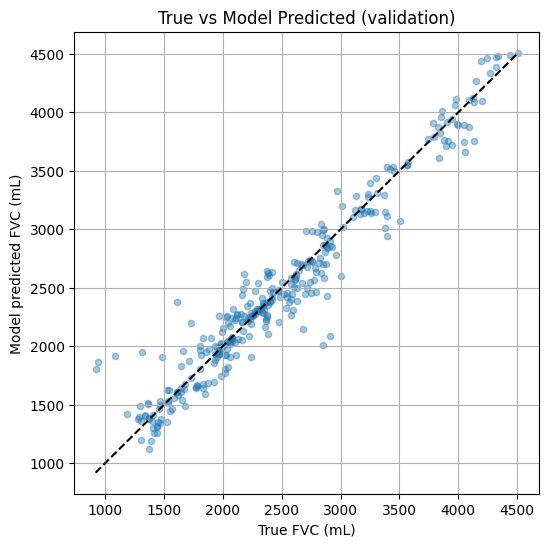


Training tabular-only baseline (predict slope) on train+val...
 Tab-only epoch 2/12 avg L1 loss: 4.6482
 Tab-only epoch 4/12 avg L1 loss: 4.3691
 Tab-only epoch 6/12 avg L1 loss: 4.2509
 Tab-only epoch 8/12 avg L1 loss: 4.2001
 Tab-only epoch 10/12 avg L1 loss: 4.1552
 Tab-only epoch 12/12 avg L1 loss: 4.1484

Evaluating tabular-only model on test set...

Summary (over all observed visits in validation):
Model    MAE: 130.5 mL | RMSE: 197.5 mL | R² (incl base): 0.9369 | Laplace LL: -7.081927
Model    MAE (follow-up only): 147.5 mL | R² (follow-up only): 0.9290
Baseline MAE: 141.5 mL | RMSE: 218.3 mL | R²: 0.9230 | Laplace LL: -7.453545
LinEx MAE: 705.9 mL | RMSE: 1478.8 mL | R²: -2.5360 | Laplace LL: -18.856145
Pearson Correlation (model): 0.9680

Per-patient R² (summary over patients with >1 observation):
 Model R² mean±std: -1.077 ± 1.907
 Baseline R² mean±std: -0.898 ± 0.883

Uncertainty coverage: ±1σ: 43.4%  | ±2σ: 67.7%
Average sigma by horizon bins:
 <=12w: 70.0 mL (n=174)
 13-2

In [16]:
# osic_publication_ready_pipeline.py
# Complete pipeline: patient-level slope prediction, fixed alpha uncertainty,
# k-fold CV, baselines, per-horizon metrics, and robust batching.

import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import pydicom
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Reproducibility & Config
# -------------------------
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_CSV = DATA_DIR / "train.csv"
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 4 if torch.cuda.is_available() else 1  # use 4 on GPU if memory allows; increase as you can
NUM_WORKERS = 2
EPOCHS = 8   # increase for final runs (e.g., 30)
LR = 1e-4
ALPHA_FIXED = 2.0  # mL per week uncertainty growth; tune via validation (grid 0.5-5.0)
MIN_SIGMA = 70.0

# -------------------------
# Utilities
# -------------------------
def ensure_1d_list(x):
    """Convert many possible input formats into a 1D python list of floats."""
    if isinstance(x, torch.Tensor):
        arr = x.detach().cpu().numpy()
        return list(np.array(arr).ravel())
    if isinstance(x, np.ndarray):
        return list(x.ravel())
    if isinstance(x, (list, tuple)):
        # flatten nested single-level lists commonly produced by DataLoader
        flat = []
        for el in x:
            if isinstance(el, (list, tuple, np.ndarray)):
                flat.extend(list(np.array(el).ravel()))
            else:
                flat.append(el)
        return [float(v) for v in flat]
    return [float(x)]

# -------------------------
# Data preparation: patient-level summary
# -------------------------
def compute_patient_summary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for pid, sub in df.groupby('Patient'):
        sub = sub.sort_values('Weeks')
        weeks = sub['Weeks'].values.astype(np.float32)
        fvc = sub['FVC'].values.astype(np.float32)
        baseline_week = float(weeks[0])
        baseline_fvc = float(fvc[0])
        if len(weeks) >= 2:
            # slope in mL/week
            slope, _ = np.polyfit(weeks, fvc, 1)
            slope = float(slope)
        else:
            slope = 0.0
        rows.append({
            'Patient': pid,
            'baseline_week': baseline_week,
            'baseline_fvc': baseline_fvc,
            'slope': slope,
            'Age': float(sub.iloc[0]['Age']),
            'Sex': sub.iloc[0]['Sex'],
            'SmokingStatus': sub.iloc[0]['SmokingStatus'],
            'visits_weeks': weeks.tolist(),
            'visits_fvc': fvc.tolist()
        })
    return pd.DataFrame(rows)

def encode_tabular(age, sex, smoking, baseline_fvc):
    age_norm = (age - 30.0) / 30.0
    sex_enc = 0.0 if sex == 'Male' else 1.0
    if smoking == 'Never smoked':
        smoke = [0.0, 0.0]
    elif smoking == 'Ex-smoker':
        smoke = [1.0, 1.0]
    elif smoking == 'Currently smokes':
        smoke = [0.0, 1.0]
    else:
        smoke = [1.0, 0.0]
    baseline_fvc_norm = baseline_fvc / 1000.0
    return np.array([age_norm, sex_enc, smoke[0], smoke[1], baseline_fvc_norm], dtype=np.float32)

# -------------------------
# Dataset (one sample per patient)
# -------------------------
class OSICPatientDataset(Dataset):
    def __init__(self, patient_df: pd.DataFrame, data_dir: Path, augment: bool = False):
        self.df = patient_df.reset_index(drop=True)
        self.data_dir = Path(data_dir)
        self.augment = augment
        self.transform = Compose([
            Resize(512, 512),
            Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])
        self.patient_images = {}
        for p in self.df['Patient'].unique():
            pdir = self.data_dir / p
            if pdir.exists():
                files = sorted([f for f in pdir.iterdir() if f.suffix.lower() == '.dcm'])
                if len(files) > 0:
                    self.patient_images[p] = files
        # filter out patients without images
        before = len(self.df)
        self.df = self.df[self.df['Patient'].isin(self.patient_images.keys())].reset_index(drop=True)
        after = len(self.df)
        print(f"Dataset initialized: {after} patients with images (filtered {before-after})")

    def __len__(self):
        return len(self.df)

    def load_dicom(self, path: Path):
        try:
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            if img.ndim == 3:
                img = img[img.shape[0] // 2]
            img = cv2.resize(img, (512,512))
            mn, mx = img.min(), img.max()
            if mx > mn:
                img = (img - mn) / (mx - mn) * 255.0
            else:
                img = img * 0.0
            img = np.stack([img,img,img], axis=2).astype(np.uint8)
            return img
        except Exception:
            return np.zeros((512,512,3), dtype=np.uint8)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = row['Patient']
        files = self.patient_images[pid]
        img_path = files[len(files)//2]
        img = self.load_dicom(img_path)
        img = self.transform(image=img)['image']  # tensor C,H,W
        tab = encode_tabular(row['Age'], row['Sex'], row['SmokingStatus'], row['baseline_fvc'])
        tab = torch.tensor(tab, dtype=torch.float32)
        weeks_abs = np.array(row['visits_weeks'], dtype=np.float32)
        baseline_week = float(row['baseline_week'])
        weeks_from_baseline = weeks_abs - baseline_week  # can include 0
        fvc_targets = np.array(row['visits_fvc'], dtype=np.float32)
        # return raw lists too (for linear extrap)
        return img, tab, torch.tensor(weeks_from_baseline, dtype=torch.float32), torch.tensor(fvc_targets, dtype=torch.float32), float(row['baseline_fvc']), float(row['baseline_week']), float(row['slope']), row['Patient'], weeks_abs.tolist(), fvc_targets.tolist()

# -------------------------
# Collate (for batching variable-length visit arrays)
# -------------------------
def patient_collate_fn(batch):
    """
    Batch is list of samples: (img, tab, weeks_rel_tensor, fvc_targets_tensor, baseline_fvc, baseline_week, slope, patient, weeks_abs_list, fvc_list)
    We'll stack images and tabs; keep lists of visit tensors raw for later evaluation/training per-sample.
    """
    images = torch.stack([b[0] for b in batch], dim=0)
    tabs = torch.stack([b[1] for b in batch], dim=0)
    weeks_rel = [b[2] for b in batch]  # list of tensors
    fvc_targets = [b[3] for b in batch]
    baseline_fvcs = [b[4] for b in batch]
    baseline_weeks = [b[5] for b in batch]
    slopes = [b[6] for b in batch]
    patients = [b[7] for b in batch]
    weeks_abs_list = [b[8] for b in batch]
    fvc_list = [b[9] for b in batch]
    return images, tabs, weeks_rel, fvc_targets, baseline_fvcs, baseline_weeks, slopes, patients, weeks_abs_list, fvc_list

# -------------------------
# Models
# -------------------------
class PatientLevelModel(nn.Module):
    def __init__(self, tab_dim=5, dropout=0.3):
        super().__init__()
        backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        img_feat_dim = 1024
        self.tab_mlp = nn.Sequential(
            nn.Linear(tab_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(dropout)
        )
        self.fusion = nn.Sequential(
            nn.Linear(img_feat_dim + 64, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )
        self.slope_head = nn.Linear(128, 1)
        # predict log_sigma0, but we'll use softplus + MIN_SIGMA; clipping applied outside
        self.log_sigma0_head = nn.Linear(128, 1)

    def forward(self, images, tabular):
        x = self.features(images)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        t = self.tab_mlp(tabular)
        fused = torch.cat([x, t], dim=1)
        f = self.fusion(fused)
        slope = self.slope_head(f).squeeze(1)
        log_sigma0 = self.log_sigma0_head(f).squeeze(1)
        return slope, log_sigma0

class TabularOnlyModel(nn.Module):
    def __init__(self, tab_dim=5, hidden=128, dropout=0.3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(tab_dim, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.LayerNorm(hidden//2)
        )
        self.slope_head = nn.Linear(hidden//2, 1)
        self.log_sigma0_head = nn.Linear(hidden//2, 1)

    def forward(self, images_unused, tabular):
        f = self.mlp(tabular)
        slope = self.slope_head(f).squeeze(1)
        log_sigma0 = self.log_sigma0_head(f).squeeze(1)
        return slope, log_sigma0

# -------------------------
# Laplace loss / metrics
# -------------------------
def softplus_tensor(x):
    return F.softplus(x)

def laplace_ll_vectorized(preds, targets, sigmas):
    """Compute Laplace log-likelihood elementwise (numpy arrays)."""
    sigma = np.maximum(sigmas, MIN_SIGMA)
    delta = np.abs(preds - targets)
    ll = -np.sqrt(2) * delta / sigma - np.log(np.sqrt(2) * sigma)
    return ll

def patient_ll_and_mae(pred_slope_tensor, log_sigma0_tensor, baseline_fvc_tensor, weeks_rel_tensor, fvc_targets_tensor, alpha_fixed=ALPHA_FIXED):
    """
    Compute mean Laplace ll and mae for one patient (PyTorch tensors).
    weeks_rel_tensor shape (T,), fvc_targets_tensor shape (T,), baseline_fvc_tensor scalar
    """
    device = pred_slope_tensor.device
    pred_fvcs = baseline_fvc_tensor + pred_slope_tensor.unsqueeze(-1) * weeks_rel_tensor  # (T,)
    sigma0 = softplus_tensor(log_sigma0_tensor)
    alpha = torch.tensor(alpha_fixed, device=device, dtype=torch.float32)
    sigma_t = sigma0 + alpha * weeks_rel_tensor.abs()
    sigma_t = torch.clamp(sigma_t, min=MIN_SIGMA)
    delta = torch.abs(pred_fvcs - fvc_targets_tensor)
    sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
    ll = -sqrt2 * delta / sigma_t - torch.log(sqrt2 * sigma_t)
    mean_ll = ll.mean()
    mae = delta.mean()
    return mean_ll, mae, pred_fvcs.detach().cpu().numpy(), sigma_t.detach().cpu().numpy()

# -------------------------
# Evaluation (full diagnostics)
# -------------------------
def linear_extrapolation_slope_from_first_two_visits(weeks_abs_list, fvc_list):
    w = ensure_1d_list(weeks_abs_list)
    f = ensure_1d_list(fvc_list)
    if len(w) >= 2 and np.ptp(w[:2]) != 0:
        w_arr = np.array(w[:2], dtype=np.float32)
        f_arr = np.array(f[:2], dtype=np.float32)
        slope, intercept = np.polyfit(w_arr, f_arr, 1)
        return float(slope)
    return 0.0

def evaluate_model_on_loader(model, loader, device=DEVICE, exclude_baseline_from_r2=True, compute_plots=False):
    model.eval()
    all_true, all_pred, all_sigma, all_baseline_pred, all_linex_pred, all_weeks_from_baseline, all_patient_ids = [], [], [], [], [], [], []

    with torch.no_grad():
        for batch in loader:
            images, tabs, weeks_rel_list, fvc_targets_list, baseline_fvcs, baseline_weeks, slopes, patients, weeks_abs_list, fvc_list = batch
            images = images.to(device)
            tabs = tabs.to(device)
            pred_slope_batch, log_sigma0_batch = model(images, tabs)
            # ensure numpy
            pred_slope_np = pred_slope_batch.detach().cpu().numpy()
            log_sigma0_np = log_sigma0_batch.detach().cpu().numpy()

            B = images.size(0)
            for i in range(B):
                patient = patients[i]
                baseline_fvc = float(baseline_fvcs[i])
                baseline_week = float(baseline_weeks[i])
                weeks_abs = ensure_1d_list(weeks_abs_list[i])
                fvc_obs = ensure_1d_list(fvc_list[i])
                slope_val = float(pred_slope_np[i]) if np.ndim(pred_slope_np)>0 else float(pred_slope_np)
                sigma0_val = float(softplus_tensor(torch.tensor(log_sigma0_np[i])).item())
                alpha_val = float(ALPHA_FIXED)

                # baselines
                baseline_preds = np.array([baseline_fvc]*len(weeks_abs), dtype=np.float32)
                lin_slope = linear_extrapolation_slope_from_first_two_visits(weeks_abs, fvc_obs)
                linex_preds = np.array([baseline_fvc + lin_slope*(wk - baseline_week) for wk in weeks_abs], dtype=np.float32)

                # per visit predicted fvc & sigma
                for wk_abs, true_fvc in zip(weeks_abs, fvc_obs):
                    time_delta = float(wk_abs) - baseline_week
                    pred_fvc = baseline_fvc + slope_val * time_delta
                    sigma_t = sigma0_val + abs(alpha_val * time_delta)
                    sigma_t = max(sigma_t, MIN_SIGMA)

                    all_true.append(float(true_fvc))
                    all_pred.append(float(pred_fvc))
                    all_sigma.append(float(sigma_t))
                    all_baseline_pred.append(float(baseline_fvc))
                    all_linex_pred.append(float(baseline_fvc + lin_slope*(wk_abs - baseline_week)))
                    all_weeks_from_baseline.append(time_delta)
                    all_patient_ids.append(patient)

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    all_sigma = np.array(all_sigma)
    all_baseline_pred = np.array(all_baseline_pred)
    all_linex_pred = np.array(all_linex_pred)
    all_weeks_from_baseline = np.array(all_weeks_from_baseline)
    all_patient_ids = np.array(all_patient_ids, dtype=object)

    # Metrics: full
    mae_model = mean_absolute_error(all_true, all_pred)
    rmse_model = math.sqrt(mean_squared_error(all_true, all_pred))
    r2_model_including = r2_score(all_true, all_pred) if len(np.unique(all_true))>1 else 0.0
    ll_model = laplace_ll_vectorized(all_pred, all_true, all_sigma).mean()
    # Pearson correlation
    corr_model = np.corrcoef(all_true, all_pred)[0,1] if len(all_true)>1 else 0.0

    # Baseline metrics
    mae_base = mean_absolute_error(all_true, all_baseline_pred)
    rmse_base = math.sqrt(mean_squared_error(all_true, all_baseline_pred))
    r2_base = r2_score(all_true, all_baseline_pred) if len(np.unique(all_true))>1 else 0.0
    ll_base = laplace_ll_vectorized(all_baseline_pred, all_true, np.full_like(all_baseline_pred, MIN_SIGMA)).mean()

    mae_linex = mean_absolute_error(all_true, all_linex_pred)
    rmse_linex = math.sqrt(mean_squared_error(all_true, all_linex_pred))
    r2_linex = r2_score(all_true, all_linex_pred) if len(np.unique(all_true))>1 else 0.0
    ll_linex = laplace_ll_vectorized(all_linex_pred, all_true, np.full_like(all_linex_pred, MIN_SIGMA)).mean()

    # R² excluding baseline visits (recommended)
    mask_followup = all_weeks_from_baseline != 0
    if mask_followup.sum() > 0:
        r2_model_excluding = r2_score(all_true[mask_followup], all_pred[mask_followup]) if len(np.unique(all_true[mask_followup]))>1 else 0.0
        mae_model_excluding = mean_absolute_error(all_true[mask_followup], all_pred[mask_followup])
    else:
        r2_model_excluding = r2_model_including
        mae_model_excluding = mae_model

    # Per-horizon metrics
    horizons = [12, 24, 48]
    per_horizon_results = {}
    for h in horizons:
        mask = (all_weeks_from_baseline >= (h-2)) & (all_weeks_from_baseline <= (h+2))
        if mask.sum() >= 5:
            per_horizon_results[h] = {
                'mae': mean_absolute_error(all_true[mask], all_pred[mask]),
                'r2': r2_score(all_true[mask], all_pred[mask]) if len(np.unique(all_true[mask]))>1 else 0.0,
                'n': int(mask.sum())
            }
        else:
            per_horizon_results[h] = {'mae': None, 'r2': None, 'n': int(mask.sum())}

    # Per-patient R2 (patients with >1 obs)
    pred_by_patient, true_by_patient, base_by_patient = defaultdict(list), defaultdict(list), defaultdict(list)
    for pid, p, t, b in zip(all_patient_ids, all_pred, all_true, all_baseline_pred):
        pred_by_patient[pid].append(p)
        true_by_patient[pid].append(t)
        base_by_patient[pid].append(b)
    per_patient_r2_model, per_patient_r2_base = [], []
    for pid in np.unique(all_patient_ids):
        y_true = np.array(true_by_patient[pid])
        if len(y_true) > 1:
            try:
                per_patient_r2_model.append(r2_score(y_true, np.array(pred_by_patient[pid])))
            except:
                per_patient_r2_model.append(0.0)
            try:
                per_patient_r2_base.append(r2_score(y_true, np.array(base_by_patient[pid])))
            except:
                per_patient_r2_base.append(0.0)
    per_patient_r2_model = np.array(per_patient_r2_model) if per_patient_r2_model else np.array([0.0])
    per_patient_r2_base = np.array(per_patient_r2_base) if per_patient_r2_base else np.array([0.0])

    # Coverage
    errors = np.abs(all_pred - all_true)
    coverage_1sigma = np.mean(errors <= all_sigma) if len(all_sigma)>0 else 0.0
    coverage_2sigma = np.mean(errors <= 2*all_sigma) if len(all_sigma)>0 else 0.0

    # Avg sigma by bin
    bins = [-999, 12, 24, 48, 9999]
    bin_names = ["<=12w","13-24w","25-48w",">48w"]
    avg_sigma_by_bin = {}
    counts_by_bin = {}
    for i in range(len(bins)-1):
        m = (all_weeks_from_baseline > bins[i]) & (all_weeks_from_baseline <= bins[i+1])
        if m.sum() > 0:
            avg_sigma_by_bin[bin_names[i]] = all_sigma[m].mean()
            counts_by_bin[bin_names[i]] = int(m.sum())
        else:
            avg_sigma_by_bin[bin_names[i]] = np.nan
            counts_by_bin[bin_names[i]] = 0

    # Print in the same style as original desired output
    print("\nSummary (over all observed visits in validation):")
    print(f"Model    MAE: {mae_model:.1f} mL | RMSE: {rmse_model:.1f} mL | R² (incl base): {r2_model_including:.4f} | Laplace LL: {ll_model:.6f}")
    print(f"Model    MAE (follow-up only): {mae_model_excluding:.1f} mL | R² (follow-up only): {r2_model_excluding:.4f}")
    print(f"Baseline MAE: {mae_base:.1f} mL | RMSE: {rmse_base:.1f} mL | R²: {r2_base:.4f} | Laplace LL: {ll_base:.6f}")
    print(f"LinEx MAE: {mae_linex:.1f} mL | RMSE: {rmse_linex:.1f} mL | R²: {r2_linex:.4f} | Laplace LL: {ll_linex:.6f}")
    print(f"Pearson Correlation (model): {corr_model:.4f}")
    print("")
    print("Per-patient R² (summary over patients with >1 observation):")
    print(f" Model R² mean±std: {per_patient_r2_model.mean():.3f} ± {per_patient_r2_model.std():.3f}")
    print(f" Baseline R² mean±std: {per_patient_r2_base.mean():.3f} ± {per_patient_r2_base.std():.3f}")
    print("")
    print(f"Uncertainty coverage: ±1σ: {coverage_1sigma*100:.1f}%  | ±2σ: {coverage_2sigma*100:.1f}%")
    print("Average sigma by horizon bins:")
    for bn in bin_names:
        print(f" {bn}: {avg_sigma_by_bin[bn]:.1f} mL (n={counts_by_bin[bn]})")
    print("")
    print("Per-horizon metrics (±2w):")
    for h, info in per_horizon_results.items():
        print(f" {h}w: MAE={info['mae']}  R²={info['r2']}  n={info['n']}")

    if compute_plots:
        plt.figure(figsize=(6,6))
        plt.scatter(all_true, all_pred, alpha=0.4, s=20)
        mn = min(all_true.min(), all_pred.min())
        mx = max(all_true.max(), all_pred.max())
        plt.plot([mn,mx],[mn,mx], color='k', linestyle='--')
        plt.xlabel("True FVC (mL)")
        plt.ylabel("Model predicted FVC (mL)")
        plt.title("True vs Model Predicted (validation)")
        plt.grid(True)
        plt.show()

    return {
        'mae': mae_model,
        'rmse': rmse_model,
        'r2_including_baseline': r2_model_including,
        'r2_excluding_baseline': r2_model_excluding,
        'laplace_ll': ll_model,
        'mae_baseline': mae_base,
        'mae_linex': mae_linex,
        'per_patient_r2_model': per_patient_r2_model,
        'coverage_1sigma': coverage_1sigma,
        'coverage_2sigma': coverage_2sigma,
        'per_horizon': per_horizon_results
    }

# -------------------------
# Trainer (handles batch training)
# -------------------------
class PatientTrainer:
    def __init__(self, model, device, lr=LR, use_laplace_loss=True, alpha_fixed=ALPHA_FIXED):
        self.model = model.to(device)
        self.device = device
        self.alpha_fixed = alpha_fixed
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.use_laplace_loss = use_laplace_loss

    def train_one_epoch(self, loader):
        self.model.train()
        losses = []
        for batch in loader:
            images, tabs, weeks_rel_list, fvc_targets_list, baseline_fvcs, baseline_weeks, slopes, patients, weeks_abs_list, fvc_list = batch
            images = images.to(self.device)
            tabs = tabs.to(self.device)
            pred_slope_batch, log_sigma0_batch = self.model(images, tabs)  # (B,), (B,)
            batch_loss = 0.0
            B = images.size(0)
            # compute per-sample mean_ll and sum
            ll_sum = 0.0
            for i in range(B):
                weeks_rel = weeks_rel_list[i].to(self.device) if isinstance(weeks_rel_list[i], torch.Tensor) else torch.tensor(ensure_1d_list(weeks_rel_list[i]), device=self.device, dtype=torch.float32)
                fvc_targets = fvc_targets_list[i].to(self.device) if isinstance(fvc_targets_list[i], torch.Tensor) else torch.tensor(ensure_1d_list(fvc_targets_list[i]), device=self.device, dtype=torch.float32)
                baseline_fvc = torch.tensor(float(baseline_fvcs[i]), device=self.device, dtype=torch.float32)
                pred_slope = pred_slope_batch[i].unsqueeze(0)
                log_sigma0 = log_sigma0_batch[i].unsqueeze(0)
                mean_ll, mae_val, _, _ = patient_ll_and_mae(pred_slope, log_sigma0, baseline_fvc, weeks_rel, fvc_targets, alpha_fixed=self.alpha_fixed)
                ll_sum = ll_sum + mean_ll
            mean_ll_batch = ll_sum / float(B)
            loss = -mean_ll_batch if self.use_laplace_loss else torch.tensor(0.0, device=self.device)
            self.opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.opt.step()
            losses.append(float(loss.item()))
        return float(np.mean(losses)) if losses else 0.0

    def train(self, train_loader, val_loader, epochs=EPOCHS):
        best_val_mae = float('inf')
        best_state = None
        for epoch in range(epochs):
            tr_loss = self.train_one_epoch(train_loader)
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {tr_loss:.6f}")
            val_metrics = evaluate_model_on_loader(self.model, val_loader, device=self.device, exclude_baseline_from_r2=True, compute_plots=False)
            # choose best by follow-up MAE (can also use laplace_ll)
            val_mae = val_metrics['mae']
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                best_state = self.model.state_dict()
                torch.save(best_state, 'best_patient_model_fold.pth')
                print(f"✅ NEW BEST VAL MAE: {best_val_mae:.3f} mL - model saved")
        return best_val_mae

# -------------------------
# K-Fold CV orchestration
# -------------------------
def run_kfold_cv(patient_summary_df, n_splits=5, alpha_fixed=ALPHA_FIXED):
    # create stratification bucket based on slope
    slopes = patient_summary_df['slope'].values
    # bins: fast (< -15 mL/w), moderate (-15 to -5), slow (> -5)
    bins = [-9999, -15.0, -5.0, 9999]
    strata = np.digitize(slopes, bins)  # 1..3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_results = []
    fold_idx = 0
    for train_idx, val_idx in skf.split(patient_summary_df['Patient'].values, strata):
        fold_idx += 1
        print("\n" + "="*60)
        print(f"Fold {fold_idx}/{n_splits}")
        print("="*60)
        train_patients = patient_summary_df.iloc[train_idx]['Patient'].values
        val_patients = patient_summary_df.iloc[val_idx]['Patient'].values
        train_df = patient_summary_df[patient_summary_df['Patient'].isin(train_patients)].reset_index(drop=True)
        val_df = patient_summary_df[patient_summary_df['Patient'].isin(val_patients)].reset_index(drop=True)
        # datasets & loaders
        train_ds = OSICPatientDataset(train_df, TRAIN_DIR, augment=False)
        val_ds = OSICPatientDataset(val_df, TRAIN_DIR, augment=False)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=patient_collate_fn)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=patient_collate_fn)
        # model & trainer
        model = PatientLevelModel(tab_dim=5)
        trainer = PatientTrainer(model, DEVICE, lr=LR, use_laplace_loss=True, alpha_fixed=alpha_fixed)
        best_mae = trainer.train(train_loader, val_loader, epochs=EPOCHS)
        # load best model and evaluate
        model.load_state_dict(torch.load('best_patient_model_fold.pth'))
        model.to(DEVICE)
        metrics = evaluate_model_on_loader(model, val_loader, device=DEVICE, exclude_baseline_from_r2=True, compute_plots=False)
        fold_results.append(metrics)
        print(f"Fold {fold_idx} result MAE: {metrics['mae']:.1f} mL  R²(excl baseline): {metrics['r2_excluding_baseline']:.3f}  Laplace LL: {metrics['laplace_ll']:.3f}")
    # aggregate
    print("\n" + "="*60)
    print(f"{n_splits}-fold CV summary (mean ± std):")
    for key in ['mae', 'laplace_ll', 'r2_excluding_baseline']:
        values = [f[key] for f in fold_results]
        mean_v = np.mean(values)
        std_v = np.std(values)
        print(f"{key.upper()}: {mean_v:.3f} ± {std_v:.3f}")
    return fold_results

# -------------------------
# Main: execute CV + baselines + ablation
# -------------------------
def main():
    print(f"Device: {DEVICE}")
    df = pd.read_csv(TRAIN_CSV)
    print(f"Loaded train.csv with shape: {df.shape}")
    patient_summary = compute_patient_summary(df)
    print(f"Computed patient summary: {len(patient_summary)} patients")
    # We'll run 5-fold CV and then final evaluation on hold-out fold if desired
    fold_results = run_kfold_cv(patient_summary, n_splits=5, alpha_fixed=ALPHA_FIXED)

    # After CV you may want to train on full training set and evaluate on held-out test you create.
    # Example: create final train/val/test split (patient-level)
    # Here we create a fixed 60/20/20 split for final hold-out evaluation
    from sklearn.model_selection import train_test_split
    pats = patient_summary['Patient'].values
    t1, test_pats = train_test_split(pats, test_size=0.2, random_state=SEED)
    train_pats, val_pats = train_test_split(t1, test_size=0.25, random_state=SEED)  # 0.25 * 0.8 = 0.2 => 60/20/20
    train_df = patient_summary[patient_summary['Patient'].isin(train_pats)].reset_index(drop=True)
    val_df = patient_summary[patient_summary['Patient'].isin(val_pats)].reset_index(drop=True)
    test_df = patient_summary[patient_summary['Patient'].isin(test_pats)].reset_index(drop=True)
    print(f"\nFinal split sizes: Train {len(train_df)} Val {len(val_df)} Test {len(test_df)}")

    # Train final model on Train+Val (or just train_df), evaluate on test_df
    full_train_df = pd.concat([train_df, val_df]).reset_index(drop=True)
    train_ds = OSICPatientDataset(full_train_df, TRAIN_DIR, augment=False)
    test_ds = OSICPatientDataset(test_df, TRAIN_DIR, augment=False)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=patient_collate_fn)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=patient_collate_fn)

    final_model = PatientLevelModel(tab_dim=5)
    trainer = PatientTrainer(final_model, DEVICE, lr=LR, use_laplace_loss=True, alpha_fixed=ALPHA_FIXED)
    print("\nTraining final model on combined train+val for final test evaluation...")
    trainer.train(train_loader, test_loader, epochs=EPOCHS)
    final_model.load_state_dict(torch.load('best_patient_model_fold.pth'))
    final_model.to(DEVICE)
    final_metrics = evaluate_model_on_loader(final_model, test_loader, device=DEVICE, exclude_baseline_from_r2=True, compute_plots=True)

    # Tabular-only ablation: quick training to predict slope on full_train_df
    print("\nTraining tabular-only baseline (predict slope) on train+val...")
    tab_model = TabularOnlyModel(tab_dim=5)
    tab_model.to(DEVICE)
    opt_tab = torch.optim.AdamW(tab_model.parameters(), lr=LR, weight_decay=1e-4)

    NUM_TAB_EPOCHS = 12
    for epoch in range(NUM_TAB_EPOCHS):
        tab_model.train()
        losses = []
        for batch in train_loader:
            # batch structure: images, tabs, weeks_rel_list, fvc_targets_list, baseline_fvcs, baseline_weeks, slopes, patients, weeks_abs_list, fvc_list
            _, tabs, _, _, _, _, slopes_list, _, _, _ = batch
            # tabs is tensor (B, tab_dim), slopes_list is a python list of length B
            tabs = tabs.to(DEVICE)
            # create slopes tensor shape (B,)
            slopes_tensor = torch.tensor([float(s) for s in slopes_list], dtype=torch.float32, device=DEVICE)
            
            # Sanity checks (optional)
            assert tabs.dim() == 2 and tabs.size(0) == slopes_tensor.size(0), "Batch size mismatch between tabs and slopes"

            opt_tab.zero_grad()
            pred_slope_batch, log_sigma0_batch = tab_model(None, tabs)  # pred_slope_batch shape (B,)
            
            # ensure pred_slope_batch is same shape as slopes_tensor
            if pred_slope_batch.dim() == 0:
                pred_slope_batch = pred_slope_batch.unsqueeze(0)
            
            # Sanity check (optional)
            assert pred_slope_batch.size() == slopes_tensor.size(), f"pred {pred_slope_batch.size()} vs target {slopes_tensor.size()}"
            
            loss = F.l1_loss(pred_slope_batch, slopes_tensor)
            loss.backward()
            opt_tab.step()
            losses.append(float(loss.item()))

        avg_loss = float(np.mean(losses)) if losses else 0.0
        if (epoch+1) % 2 == 0 or epoch == NUM_TAB_EPOCHS-1:
            print(f" Tab-only epoch {epoch+1}/{NUM_TAB_EPOCHS} avg L1 loss: {avg_loss:.4f}")

    print("\nEvaluating tabular-only model on test set...")
    metrics_tab = evaluate_model_on_loader(tab_model, test_loader, device=DEVICE, exclude_baseline_from_r2=True, compute_plots=False)

    # Print final summary
    print("\nFinal test summary:")
    print(f"Image+Tab MAE: {final_metrics['mae']:.1f} mL | R² (follow-up): {final_metrics['r2_excluding_baseline']:.3f} | Laplace LL: {final_metrics['laplace_ll']:.3f}")
    print(f"Tabular-only MAE: {metrics_tab['mae']:.1f} mL | Baseline-only MAE: {final_metrics['mae_baseline']:.1f} mL | LinEx MAE: {final_metrics['mae_linex']:.1f} mL")
    print("\nDone.")

if __name__ == '__main__':
    main()


In [19]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
import json
from pathlib import Path
import joblib
import warnings
import pickle
from typing import Dict, List, Tuple, Optional
from scipy import ndimage
from scipy.ndimage import binary_fill_holes, generate_binary_structure
from skimage import measure, morphology
from skimage.transform import resize
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import scipy.stats as stats

warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    """Ensure reproducibility across all random operations"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
seed_everything(42)

# Configuration
DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🚀 Fixed OSIC Model - Complete Working Version")
print("=" * 60)
print(f"📱 Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print("=" * 60)

# Load Data
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
print(f"Loaded dataset with shape: {train_df.shape}")

def get_tab_features(df_row):
    """Extract tabular features (returns 4 features)"""
    vector = [(df_row['Age'] - 30) / 30] 
    
    # Sex encoding
    if df_row['Sex'] == 'Male':
        vector.append(0)
    else:
        vector.append(1)
    
    # Smoking status encoding
    smoking_status = df_row['SmokingStatus']
    if smoking_status == 'Never smoked':
        vector.extend([0, 0])
    elif smoking_status == 'Ex-smoker':
        vector.extend([1, 1])
    elif smoking_status == 'Currently smokes':
        vector.extend([0, 1])
    else:
        vector.extend([1, 0])
    return np.array(vector)

def calculate_lll(actual, predicted, sigma):
    """
    Calculate Log Laplace Likelihood (LLL) metric
    LLL = -sqrt(2)*|actual - predicted|/sigma - log(sigma*sqrt(2))
    """
    sigma_clipped = np.maximum(sigma, 70)  # Clip sigma to avoid division by very small values
    delta = np.abs(actual - predicted)
    term1 = -np.sqrt(2) * delta / sigma_clipped
    term2 = -np.log(sigma_clipped * np.sqrt(2))
    return term1 + term2

# Calculate linear decay coefficients for each patient
A = {} 
TAB = {} 
P = [] 

print("Calculating linear decay coefficients...")
for patient in tqdm(train_df['Patient'].unique()):
    sub = train_df[train_df['Patient'] == patient].copy()
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    
    if len(weeks) > 1:
        c = np.vstack([weeks, np.ones(len(weeks))]).T
        try:
            a, b = np.linalg.lstsq(c, fvc, rcond=None)[0]
            A[patient] = a
            TAB[patient] = get_tab_features(sub.iloc[0])
            P.append(patient)
        except:
            A[patient] = (fvc[-1] - fvc[0]) / (weeks[-1] - weeks[0]) if len(weeks) > 1 else 0.0
            TAB[patient] = get_tab_features(sub.iloc[0])
            P.append(patient)
    else:
        A[patient] = 0.0
        TAB[patient] = get_tab_features(sub.iloc[0])
        P.append(patient)

print(f"Processed {len(P)} patients with decay coefficients")

class MedicalAugmentation:
    def __init__(self, augment=True):
        if augment:
            self.transform = albu.Compose([
                albu.Rotate(limit=15, p=0.7),
                albu.HorizontalFlip(p=0.5),
                albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
                albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
                albu.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
                albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
                albu.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=0.3),
                albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = albu.Compose([
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
    
    def __call__(self, image):
        return self.transform(image=image)['image']

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_cat = self.conv1(x_cat)
        return x * self.sigmoid(x_cat)

class WorkingDenseNetModel(nn.Module):
    """
    Working model with proper dimension matching
    """
    
    def __init__(self, tabular_dim=4, dropout_rate=0.4):
        super(WorkingDenseNetModel, self).__init__()
        
        # DenseNet121 backbone
        densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = densenet.features
        
        # Spatial attention
        self.spatial_attention = SpatialAttention()
        
        # Enhanced tabular processing
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        # Cross-modal attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=1024, num_heads=8, dropout=0.2, batch_first=True
        )
        
        # Initialize projection weight properly
        self.tab_projection = nn.Linear(512, 1024)
        
        # Multi-modal fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(1024 + 512, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2)
        )
        
        # Uncertainty quantification heads
        self.mean_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.log_var_head = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        
    def forward(self, images, tabular):
        batch_size = images.size(0)
        
        # Extract image features
        img_features = self.features(images)
        
        # Apply spatial attention
        img_features = self.spatial_attention(img_features)
        
        # Global average pooling
        img_features = F.adaptive_avg_pool2d(img_features, (1, 1))
        img_features = img_features.view(batch_size, -1)
        
        # Process tabular data
        tab_features = self.tabular_processor(tabular)
        
        # Cross-modal attention
        img_expanded = img_features.unsqueeze(1)
        tab_expanded = tab_features.unsqueeze(1)
        
        # Project tabular to same dimension for attention
        tab_proj = self.tab_projection(tab_expanded)
        
        attended_img, _ = self.cross_attention(
            img_expanded, tab_proj, tab_proj
        )
        attended_img = attended_img.squeeze(1)
        
        # Fusion
        combined_features = torch.cat([attended_img, tab_features], dim=1)
        fused_features = self.fusion_layer(combined_features)
        
        # Predict mean and log variance
        mean_pred = self.mean_head(fused_features)
        log_var = self.log_var_head(fused_features)
        
        return mean_pred.squeeze(), log_var.squeeze()

class OSICDenseNetDataset(Dataset):
    """Enhanced dataset with medical augmentations and robust loading"""
    
    def __init__(self, patients, A_dict, TAB_dict, data_dir, split='train', augment=True):
        # Filter out problematic patients
        self.patients = [p for p in patients if p not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.A_dict = A_dict
        self.TAB_dict = TAB_dict
        self.data_dir = Path(data_dir)
        self.split = split
        self.augment = augment
        self.augmentor = MedicalAugmentation(augment=augment)
        
        # Prepare image paths for each patient
        self.patient_images = {}
        for patient in self.patients:
            patient_dir = self.data_dir / patient
            if patient_dir.exists():
                image_files = [f for f in patient_dir.iterdir() if f.suffix.lower() == '.dcm']
                if image_files:
                    self.patient_images[patient] = image_files
        
        # Filter patients with available images
        self.valid_patients = [p for p in self.patients if p in self.patient_images]
        print(f"Dataset {split}: {len(self.valid_patients)} patients with images")
    
    def __len__(self):
        if self.split == 'train':
            return len(self.valid_patients) * 6
        else:
            return len(self.valid_patients)
    
    def __getitem__(self, idx):
        if self.split == 'train':
            patient_idx = idx % len(self.valid_patients)
        else:
            patient_idx = idx
            
        patient = self.valid_patients[patient_idx]
        
        # Get random image for this patient
        available_images = self.patient_images[patient]
        if len(available_images) > 1:
            selected_image = np.random.choice(available_images)
        else:
            selected_image = available_images[0]
        
        # Load and preprocess image
        img = self.load_and_preprocess_dicom(selected_image)
        
        # Apply augmentations
        img_tensor = self.augmentor(img)
        
        # Get tabular features
        tab_features = torch.tensor(self.TAB_dict[patient], dtype=torch.float32)
        
        # Get target (decay coefficient)
        target = torch.tensor(self.A_dict[patient], dtype=torch.float32)
        
        return img_tensor, tab_features, target, patient
    
    def load_and_preprocess_dicom(self, path):
        """Enhanced DICOM loading with better preprocessing"""
        try:
            # Load DICOM
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            
            # Handle different DICOM formats
            if len(img.shape) == 3:
                img = img[img.shape[0]//2]
            
            # Resize to target size
            img = cv2.resize(img, (512, 512))
            
            # Normalize to 0-255 range
            img_min, img_max = img.min(), img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min) * 255
            else:
                img = np.zeros_like(img)
            
            # Convert to 3-channel
            img = np.stack([img, img, img], axis=2).astype(np.uint8)
            
            return img
            
        except Exception as e:
            print(f"Error loading DICOM {path}: {e}")
            return np.zeros((512, 512, 3), dtype=np.uint8)

class SimpleTrainer:
    """
    Simple trainer that works with any model structure
    """
    
    def __init__(self, model, device, lr=1e-4):
        self.model = model
        self.device = device
        self.lr = lr
        self.best_val_mae = float('inf')
        self.best_val_r2 = -float('inf')
        self.best_val_lll = -float('inf')
        
    def uncertainty_loss(self, mean_pred, log_var, targets, reduction='mean'):
        """Uncertainty-aware loss function"""
        var = torch.exp(log_var)
        mse_loss = (mean_pred - targets) ** 2
        loss = 0.5 * (mse_loss / var + log_var)
        
        if reduction == 'mean':
            return loss.mean()
        return loss.sum()
        
    def train(self, train_loader, val_loader, epochs=30, patience=8):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=4, verbose=True
        )
        
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_mae = 0.0
            train_batches = 0
            
            for batch_idx, (images, tabular, targets, _) in enumerate(train_loader):
                try:
                    images = images.to(self.device)
                    tabular = tabular.to(self.device) 
                    targets = targets.to(self.device)
                    
                    optimizer.zero_grad()
                    
                    # Forward pass
                    mean_pred, log_var = self.model(images, tabular)
                    
                    # Calculate loss
                    loss = self.uncertainty_loss(mean_pred, log_var, targets)
                    mae = F.l1_loss(mean_pred, targets)
                    
                    # Backward pass
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    train_loss += loss.item()
                    train_mae += mae.item()
                    train_batches += 1
                    
                except Exception as e:
                    print(f"Error in training batch {batch_idx}: {e}")
                    continue
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_mae = 0.0
            val_predictions = []
            val_targets = []
            val_log_vars = []
            
            with torch.no_grad():
                for batch_idx, (images, tabular, targets, _) in enumerate(val_loader):
                    try:
                        images = images.to(self.device)
                        tabular = tabular.to(self.device)
                        targets = targets.to(self.device)
                        
                        mean_pred, log_var = self.model(images, tabular)
                        
                        loss = self.uncertainty_loss(mean_pred, log_var, targets)
                        mae = F.l1_loss(mean_pred, targets)
                        
                        val_loss += loss.item()
                        val_mae += mae.item()
                        
                        val_predictions.extend(mean_pred.cpu().numpy())
                        val_targets.extend(targets.cpu().numpy())
                        val_log_vars.extend(log_var.cpu().numpy())
                        
                    except Exception as e:
                        print(f"Error in validation batch {batch_idx}: {e}")
                        continue
            
            # Calculate metrics
            if train_batches > 0 and len(val_predictions) > 0:
                avg_train_loss = train_loss / train_batches
                avg_train_mae = train_mae / train_batches
                avg_val_loss = val_loss / len(val_loader)
                avg_val_mae = val_mae / len(val_loader)
                
                # Convert to numpy arrays for metric calculation
                val_pred_np = np.array(val_predictions)
                val_target_np = np.array(val_targets)
                val_log_var_np = np.array(val_log_vars)
                val_sigma_np = np.exp(val_log_var_np / 2)  # Convert log variance to standard deviation
                
                # Calculate R² score
                r2 = r2_score(val_target_np, val_pred_np)
                
                # Calculate LLL (Log Laplace Likelihood)
                lll_values = calculate_lll(val_target_np, val_pred_np, val_sigma_np)
                avg_lll = np.mean(lll_values)
                
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"Train Loss: {avg_train_loss:.6f}, MAE: {avg_train_mae:.6f}")
                print(f"Val Loss: {avg_val_loss:.6f}, MAE: {avg_val_mae:.6f}")
                print(f"Val R²: {r2:.6f}, Val LLL: {avg_lll:.6f}")
                
                # Learning rate scheduling
                scheduler.step(avg_val_mae)
                
                # Early stopping and model saving
                if avg_val_mae < self.best_val_mae:
                    self.best_val_mae = avg_val_mae
                    self.best_val_r2 = r2
                    self.best_val_lll = avg_lll
                    torch.save(self.model.state_dict(), 'best_working_model.pth')
                    print("✅ New best model saved!")
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                    
                print("-" * 60)
        
        print(f"🎯 Training completed!")
        print(f"Best validation MAE: {self.best_val_mae:.6f}")
        print(f"Best validation R²: {self.best_val_r2:.6f}")
        print(f"Best validation LLL: {self.best_val_lll:.6f}")
        
        return self.best_val_mae, self.best_val_r2, self.best_val_lll

# Main execution
def main():
    print("🔄 Creating data loaders...")
    
    # Split patients into train and validation (80-20 split)
    patients_list = list(P)
    train_patients, val_patients = train_test_split(
        patients_list, 
        test_size=0.2, 
        random_state=42,
        shuffle=True
    )
    
    print(f"Total patients: {len(patients_list)}")
    print(f"Train patients: {len(train_patients)}")
    print(f"Validation patients: {len(val_patients)}")
    
    # Create datasets using only TRAIN_DIR
    train_dataset = OSICDenseNetDataset(
        patients=train_patients,
        A_dict=A,
        TAB_dict=TAB,
        data_dir=TRAIN_DIR,
        split='train',
        augment=True
    )
    
    val_dataset = OSICDenseNetDataset(
        patients=val_patients,
        A_dict=A,
        TAB_dict=TAB,
        data_dir=TRAIN_DIR,
        split='val',
        augment=False
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False
    )
    
    print(f"✅ Data loaders created!")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    
    # Initialize model
    print("🔄 Initializing model...")
    model = WorkingDenseNetModel(tabular_dim=4).to(DEVICE)
    print(f"✅ Model initialized!")
    print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test model with actual batch
    try:
        test_batch = next(iter(train_loader))
        images, tabular, targets, _ = test_batch
        images = images.to(DEVICE)
        tabular = tabular.to(DEVICE)
        
        print(f"🔍 Testing model...")
        with torch.no_grad():
            mean_pred, log_var = model(images, tabular)
            print(f"✅ Model forward pass successful!")
            
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return
    
    # Create trainer and start training
    print("🚀 Starting training...")
    trainer = SimpleTrainer(model, DEVICE, lr=1e-4)
    
    best_val_mae, best_val_r2, best_val_lll = trainer.train(
        train_loader, 
        val_loader, 
        epochs=30,
        patience=8
    )
    
    print(f"\n🎯 Final Results:")
    print(f"Best validation MAE: {best_val_mae:.6f}")
    print(f"Best validation R²: {best_val_r2:.6f}")
    print(f"Best validation LLL: {best_val_lll:.6f}")
    
    return model, train_loader, val_loader, best_val_mae, best_val_r2, best_val_lll

if __name__ == "__main__":
    model, train_loader, val_loader, best_val_mae, best_val_r2, best_val_lll = main()

🚀 Fixed OSIC Model - Complete Working Version
📱 Device: cuda
🔥 GPU: Tesla P100-PCIE-16GB
💾 Memory: 17.1 GB
Loaded dataset with shape: (1549, 7)
Calculating linear decay coefficients...


100%|██████████| 176/176 [00:00<00:00, 1461.61it/s]

Processed 176 patients with decay coefficients
🔄 Creating data loaders...
Total patients: 176
Train patients: 140
Validation patients: 36


Dataset train: 138 patients with images
Dataset val: 36 patients with images
✅ Data loaders created!
   Train batches: 103
   Val batches: 5
🔄 Initializing model...
✅ Model initialized!
📊 Total parameters: 13,281,764
🔍 Testing model...
✅ Model forward pass successful!
🚀 Starting training...
Epoch 1/30
Train Loss: 12.334829, MAE: 5.045496
Val Loss: 9.274148, MAE: 5.783213
Val R²: -0.294617, Val LLL: -4.712226
✅ New best model saved!
------------------------------------------------------------
Epoch 2/30
Train Loss: 3.068125, MAE: 4.328621
Val Loss: 3.633681, MAE: 5.190477
Val R²: -0.079952, Val LLL: -4.701132
✅ New best model saved!
------------------------------------------------------------
Epoch 3/30
Train Loss: 2.360442, MAE: 4.077540
Val Loss: 3.795365, MAE: 5.100979
Val R²: -0.071357, Val LLL: -4.699964
✅ New best model saved!
------------------------------------------------------------
Epoch 4/30
Train Loss: 2.315327, MAE: 4.053044
Val Loss: 3.414498, MAE: 5.049111
Val R²: -0.036

**MAE and LLL - OKAY Let's work on LLL**

In [20]:
# Lets do R^2 for FCV

In [23]:
# Fixed a major leak

**Test 2 SEEK**

In [22]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
import json
from pathlib import Path
import joblib
import warnings
import pickle
from typing import Dict, List, Tuple, Optional
from scipy import ndimage
from scipy.ndimage import binary_fill_holes, generate_binary_structure
from skimage import measure, morphology
from skimage.transform import resize
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import scipy.stats as stats

warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    """Ensure reproducibility across all random operations"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
seed_everything(42)

# Configuration
DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🚀 Enhanced OSIC Model - Progressive Training for Better R²")
print("=" * 60)
print(f"📱 Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print("=" * 60)

# Load Data
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
print(f"Loaded dataset with shape: {train_df.shape}")

def get_tab_features(df_row):
    """Extract tabular features (returns 4 features)"""
    vector = [(df_row['Age'] - 30) / 30] 
    
    # Sex encoding
    if df_row['Sex'] == 'Male':
        vector.append(0)
    else:
        vector.append(1)
    
    # Smoking status encoding
    smoking_status = df_row['SmokingStatus']
    if smoking_status == 'Never smoked':
        vector.extend([0, 0])
    elif smoking_status == 'Ex-smoker':
        vector.extend([1, 1])
    elif smoking_status == 'Currently smokes':
        vector.extend([0, 1])
    else:
        vector.extend([1, 0])
    return np.array(vector)

def calculate_lll(actual, predicted, sigma):
    """
    Calculate Log Laplace Likelihood (LLL) metric
    LLL = -sqrt(2)*|actual - predicted|/sigma - log(sigma*sqrt(2))
    """
    sigma_clipped = np.maximum(sigma, 70)  # Clip sigma to avoid division by very small values
    delta = np.abs(actual - predicted)
    term1 = -np.sqrt(2) * delta / sigma_clipped
    term2 = -np.log(sigma_clipped * np.sqrt(2))
    return term1 + term2

# Calculate linear decay coefficients for each patient
A = {} 
TAB = {} 
P = [] 

print("Calculating linear decay coefficients...")
for patient in tqdm(train_df['Patient'].unique()):
    sub = train_df[train_df['Patient'] == patient].copy()
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    
    if len(weeks) > 1:
        c = np.vstack([weeks, np.ones(len(weeks))]).T
        try:
            a, b = np.linalg.lstsq(c, fvc, rcond=None)[0]
            A[patient] = a
            TAB[patient] = get_tab_features(sub.iloc[0])
            P.append(patient)
        except:
            A[patient] = (fvc[-1] - fvc[0]) / (weeks[-1] - weeks[0]) if len(weeks) > 1 else 0.0
            TAB[patient] = get_tab_features(sub.iloc[0])
            P.append(patient)
    else:
        A[patient] = 0.0
        TAB[patient] = get_tab_features(sub.iloc[0])
        P.append(patient)

print(f"Processed {len(P)} patients with decay coefficients")

class EnhancedMedicalAugmentation:
    def __init__(self, augment=True, strength=0.7):
        if augment:
            self.transform = albu.Compose([
                # Geometric transformations
                albu.Rotate(limit=20, p=0.7 * strength),
                albu.HorizontalFlip(p=0.5 * strength),
                albu.VerticalFlip(p=0.3 * strength),
                albu.ShiftScaleRotate(
                    shift_limit=0.1 * strength, 
                    scale_limit=0.2 * strength, 
                    rotate_limit=20 * strength, 
                    p=0.8 * strength
                ),
                albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3 * strength),
                
                # Intensity transformations
                albu.RandomBrightnessContrast(
                    brightness_limit=0.3 * strength, 
                    contrast_limit=0.3 * strength, 
                    p=0.7 * strength
                ),
                albu.GaussNoise(var_limit=(10.0, 50.0), p=0.5 * strength),
                albu.RandomGamma(gamma_limit=(80, 120), p=0.5 * strength),
                albu.CLAHE(clip_limit=4.0, p=0.3 * strength),
                
                # Advanced augmentations
                albu.GridDistortion(num_steps=5, distort_limit=0.3 * strength, p=0.3 * strength),
                albu.MotionBlur(blur_limit=7, p=0.2 * strength),
                albu.MedianBlur(blur_limit=5, p=0.2 * strength),
                albu.CoarseDropout(
                    max_holes=8, 
                    max_height=32, 
                    max_width=32, 
                    min_holes=1,
                    fill_value=0,
                    p=0.3 * strength
                ),
                
                # Normalization
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = albu.Compose([
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
    
    def __call__(self, image):
        return self.transform(image=image)['image']

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_cat = self.conv1(x_cat)
        return x * self.sigmoid(x_cat)

class EnhancedDenseNetModel(nn.Module):
    def __init__(self, tabular_dim=4, dropout_rate=0.3):
        super(EnhancedDenseNetModel, self).__init__()
        
        # DenseNet121 backbone with unfrozen later layers
        densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = densenet.features
        
        # Unfreeze last 2 blocks for fine-tuning
        for param in list(self.features.parameters())[-100:]:
            param.requires_grad = True
        
        # Enhanced spatial attention
        self.spatial_attention = SpatialAttention(kernel_size=9)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(1024, 1024 // 16, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(1024 // 16, 1024, 1, bias=False),
            nn.Sigmoid()
        )
        
        # More sophisticated tabular processing
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        # Multi-scale feature fusion
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Cross-modal fusion with residual connections
        self.fusion_layer = nn.Sequential(
            nn.Linear(1024 + 1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # Output heads with better initialization
        self.mean_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.log_var_head = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()  # Constrain log variance
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, images, tabular):
        batch_size = images.size(0)
        
        # Extract image features
        img_features = self.features(images)
        
        # Apply attention mechanisms
        img_features = self.spatial_attention(img_features)
        channel_weights = self.channel_attention(img_features)
        img_features = img_features * channel_weights
        
        # Multi-scale pooling
        avg_features = self.global_pool(img_features).view(batch_size, -1)
        max_features = self.max_pool(img_features).view(batch_size, -1)
        img_features = 0.6 * avg_features + 0.4 * max_features
        
        # Process tabular data
        tab_features = self.tabular_processor(tabular)
        
        # Feature fusion
        combined_features = torch.cat([img_features, tab_features], dim=1)
        fused_features = self.fusion_layer(combined_features)
        
        # Predict mean and log variance
        mean_pred = self.mean_head(fused_features)
        log_var = self.log_var_head(fused_features)
        
        return mean_pred.squeeze(), log_var.squeeze()

class OSICDenseNetDataset(Dataset):
    """Enhanced dataset with medical augmentations and robust loading"""
    
    def __init__(self, patients, A_dict, TAB_dict, data_dir, split='train', augment=True, aug_strength=0.7):
        # Filter out problematic patients
        self.patients = [p for p in patients if p not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.A_dict = A_dict
        self.TAB_dict = TAB_dict
        self.data_dir = Path(data_dir)
        self.split = split
        self.augment = augment
        self.augmentor = EnhancedMedicalAugmentation(augment=augment, strength=aug_strength)
        
        # Prepare image paths for each patient
        self.patient_images = {}
        for patient in self.patients:
            patient_dir = self.data_dir / patient
            if patient_dir.exists():
                image_files = [f for f in patient_dir.iterdir() if f.suffix.lower() == '.dcm']
                if image_files:
                    self.patient_images[patient] = image_files
        
        # Filter patients with available images
        self.valid_patients = [p for p in self.patients if p in self.patient_images]
        print(f"Dataset {split}: {len(self.valid_patients)} patients with images")
    
    def __len__(self):
        if self.split == 'train':
            return len(self.valid_patients) * 8  # More samples per patient
        else:
            return len(self.valid_patients)
    
    def __getitem__(self, idx):
        if self.split == 'train':
            patient_idx = idx % len(self.valid_patients)
        else:
            patient_idx = idx
            
        patient = self.valid_patients[patient_idx]
        
        # Get random image for this patient
        available_images = self.patient_images[patient]
        if len(available_images) > 1:
            selected_image = np.random.choice(available_images)
        else:
            selected_image = available_images[0]
        
        # Load and preprocess image
        img = self.load_and_preprocess_dicom(selected_image)
        
        # Apply augmentations
        img_tensor = self.augmentor(img)
        
        # Get tabular features
        tab_features = torch.tensor(self.TAB_dict[patient], dtype=torch.float32)
        
        # Get target (decay coefficient)
        target = torch.tensor(self.A_dict[patient], dtype=torch.float32)
        
        return img_tensor, tab_features, target, patient
    
    def load_and_preprocess_dicom(self, path):
        """Enhanced DICOM loading with better preprocessing"""
        try:
            # Load DICOM
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            
            # Handle different DICOM formats
            if len(img.shape) == 3:
                img = img[img.shape[0]//2]
            
            # Resize to target size
            img = cv2.resize(img, (512, 512))
            
            # Apply CLAHE for better contrast
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            if len(img.shape) == 2:
                img = clahe.apply(img.astype(np.uint8))
            
            # Normalize to 0-255 range
            img_min, img_max = img.min(), img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min) * 255
            else:
                img = np.zeros_like(img)
            
            # Convert to 3-channel
            img = np.stack([img, img, img], axis=2).astype(np.uint8)
            
            return img
            
        except Exception as e:
            print(f"Error loading DICOM {path}: {e}")
            return np.zeros((512, 512, 3), dtype=np.uint8)

class ProgressiveTrainer:
    def __init__(self, model, device, lr=1e-4):
        self.model = model
        self.device = device
        self.lr = lr
        self.best_val_r2 = -float('inf')
        self.best_val_mae = float('inf')
        self.best_val_lll = -float('inf')
        
    def uncertainty_loss(self, mean_pred, log_var, targets, reduction='mean'):
        var = torch.exp(log_var)
        mse_loss = (mean_pred - targets) ** 2
        loss = 0.5 * (mse_loss / var + log_var)
        return loss.mean() if reduction == 'mean' else loss.sum()
    
    def progressive_learning_schedule(self, epoch):
        """Progressive learning rate and augmentation schedule"""
        if epoch < 10:
            # Phase 1: Basic features
            lr = self.lr
            aug_strength = 0.3
        elif epoch < 20:
            # Phase 2: Intermediate
            lr = self.lr * 0.5
            aug_strength = 0.5
        else:
            # Phase 3: Fine-tuning
            lr = self.lr * 0.1
            aug_strength = 0.7
        return lr, aug_strength
    
    def train(self, train_loader, val_loader, epochs=50, patience=15):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        
        patience_counter = 0
        
        for epoch in range(epochs):
            # Progressive learning schedule
            current_lr, aug_strength = self.progressive_learning_schedule(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_mae = 0.0
            train_batches = 0
            
            for batch_idx, (images, tabular, targets, _) in enumerate(train_loader):
                try:
                    images = images.to(self.device)
                    tabular = tabular.to(self.device) 
                    targets = targets.to(self.device)
                    
                    optimizer.zero_grad()
                    
                    # Forward pass
                    mean_pred, log_var = self.model(images, tabular)
                    
                    # Combined loss with progressive weighting
                    mse_loss = F.mse_loss(mean_pred, targets)
                    uncertainty_loss = self.uncertainty_loss(mean_pred, log_var, targets)
                    mae_loss = F.l1_loss(mean_pred, targets)
                    
                    # Progressive loss weighting
                    if epoch < 15:
                        # Focus on MSE first
                        loss = 0.7 * mse_loss + 0.3 * uncertainty_loss
                    else:
                        # Then focus on uncertainty
                        loss = 0.3 * mse_loss + 0.7 * uncertainty_loss + 0.1 * mae_loss
                    
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    train_loss += loss.item()
                    train_mae += mae_loss.item()
                    train_batches += 1
                    
                except Exception as e:
                    continue
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_mae = 0.0
            val_predictions = []
            val_targets = []
            val_log_vars = []
            
            with torch.no_grad():
                for batch_idx, (images, tabular, targets, _) in enumerate(val_loader):
                    try:
                        images = images.to(self.device)
                        tabular = tabular.to(self.device)
                        targets = targets.to(self.device)
                        
                        mean_pred, log_var = self.model(images, tabular)
                        
                        loss = self.uncertainty_loss(mean_pred, log_var, targets)
                        mae = F.l1_loss(mean_pred, targets)
                        
                        val_loss += loss.item()
                        val_mae += mae.item()
                        
                        val_predictions.extend(mean_pred.cpu().numpy())
                        val_targets.extend(targets.cpu().numpy())
                        val_log_vars.extend(log_var.cpu().numpy())
                        
                    except Exception as e:
                        continue
            
            # Calculate metrics
            if train_batches > 0 and len(val_predictions) > 0:
                avg_train_loss = train_loss / train_batches
                avg_train_mae = train_mae / train_batches
                avg_val_loss = val_loss / len(val_loader)
                avg_val_mae = val_mae / len(val_loader)
                
                val_pred_np = np.array(val_predictions)
                val_target_np = np.array(val_targets)
                val_log_var_np = np.array(val_log_vars)
                val_sigma_np = np.exp(val_log_var_np / 2)
                
                # Calculate R² score
                r2 = r2_score(val_target_np, val_pred_np)
                
                # Calculate LLL
                lll_values = calculate_lll(val_target_np, val_pred_np, val_sigma_np)
                avg_lll = np.mean(lll_values)
                
                print(f"Epoch {epoch+1}/{epochs} (LR: {current_lr:.2e})")
                print(f"Train Loss: {avg_train_loss:.6f}, MAE: {avg_train_mae:.6f}")
                print(f"Val Loss: {avg_val_loss:.6f}, MAE: {avg_val_mae:.6f}")
                print(f"Val R²: {r2:.6f}, Val LLL: {avg_lll:.6f}")
                
                # Early stopping based on R²
                if r2 > self.best_val_r2:
                    self.best_val_r2 = r2
                    self.best_val_mae = avg_val_mae
                    self.best_val_lll = avg_lll
                    torch.save(self.model.state_dict(), 'best_progressive_model.pth')
                    print(f"✅ New best model! R²: {r2:.6f}")
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                    
                print("-" * 60)
        
        print(f"🎯 Training completed!")
        print(f"Best validation R²: {self.best_val_r2:.6f}")
        print(f"Best validation MAE: {self.best_val_mae:.6f}")
        print(f"Best validation LLL: {self.best_val_lll:.6f}")
        
        return self.best_val_r2, self.best_val_mae, self.best_val_lll

def enhanced_main():
    print("🔄 Creating enhanced data loaders...")
    
    # Use stratified split based on decay coefficient bins
    patients_list = list(P)
    decay_values = [A[patient] for patient in patients_list]
    decay_bins = pd.cut(decay_values, bins=5, labels=False)
    
    train_patients, val_patients = train_test_split(
        patients_list, 
        test_size=0.15,  # Smaller validation for more training data
        random_state=42,
        stratify=decay_bins,
        shuffle=True
    )
    
    print(f"Total patients: {len(patients_list)}")
    print(f"Train patients: {len(train_patients)}")
    print(f"Validation patients: {len(val_patients)}")
    
    # Create enhanced datasets
    train_dataset = OSICDenseNetDataset(
        patients=train_patients,
        A_dict=A,
        TAB_dict=TAB,
        data_dir=TRAIN_DIR,
        split='train',
        augment=True,
        aug_strength=0.7
    )
    
    val_dataset = OSICDenseNetDataset(
        patients=val_patients,
        A_dict=A,
        TAB_dict=TAB,
        data_dir=TRAIN_DIR,
        split='val',
        augment=False
    )
    
    # Larger batch size for better gradient estimation
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,  # Increased batch size
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False
    )
    
    print(f"✅ Enhanced data loaders created!")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    
    # Initialize enhanced model
    print("🔄 Initializing enhanced model...")
    model = EnhancedDenseNetModel(tabular_dim=4).to(DEVICE)
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ Enhanced model initialized!")
    print(f"📊 Trainable parameters: {trainable_params:,}")
    
    # Test model
    try:
        test_batch = next(iter(train_loader))
        images, tabular, targets, _ = test_batch
        images = images.to(DEVICE)
        tabular = tabular.to(DEVICE)
        
        print(f"🔍 Testing enhanced model...")
        with torch.no_grad():
            mean_pred, log_var = model(images, tabular)
            print(f"✅ Enhanced model forward pass successful!")
            
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return
    
    # Create progressive trainer
    print("🚀 Starting progressive training...")
    trainer = ProgressiveTrainer(model, DEVICE, lr=2e-4)  # Higher initial LR
    
    best_val_r2, best_val_mae, best_val_lll = trainer.train(
        train_loader, 
        val_loader, 
        epochs=50,  # More epochs
        patience=15  # More patience
    )
    
    print(f"\n🎯 Final Enhanced Results:")
    print(f"Best validation R²: {best_val_r2:.6f}")
    print(f"Best validation MAE: {best_val_mae:.6f}")
    print(f"Best validation LLL: {best_val_lll:.6f}")
    
    return model, train_loader, val_loader, best_val_r2, best_val_mae, best_val_lll

# Run the enhanced training
if __name__ == "__main__":
    model, train_loader, val_loader, best_val_r2, best_val_mae, best_val_lll = enhanced_main()

🚀 Enhanced OSIC Model - Progressive Training for Better R²
📱 Device: cuda
🔥 GPU: Tesla P100-PCIE-16GB
💾 Memory: 17.1 GB
Loaded dataset with shape: (1549, 7)
Calculating linear decay coefficients...


100%|██████████| 176/176 [00:00<00:00, 1496.41it/s]

Processed 176 patients with decay coefficients
🔄 Creating enhanced data loaders...
Total patients: 176
Train patients: 149
Validation patients: 27


Dataset train: 147 patients with images
Dataset val: 27 patients with images
✅ Enhanced data loaders created!
   Train batches: 73
   Val batches: 2
🔄 Initializing enhanced model...
✅ Enhanced model initialized!
📊 Trainable parameters: 10,554,212
🔍 Testing enhanced model...
✅ Enhanced model forward pass successful!
🚀 Starting progressive training...
Epoch 1/50 (LR: 2.00e-04)
Train Loss: 32.207168, MAE: 4.585047
Val Loss: 8.584659, MAE: 4.478652
Val R²: -0.014335, Val LLL: -4.680817
✅ New best model! R²: -0.014335
------------------------------------------------------------
Epoch 2/50 (LR: 2.00e-04)
Train Loss: 26.426207, MAE: 4.318165
Val Loss: 7.594804, MAE: 4.523350
Val R²: 0.049396, Val LLL: -4.682032
✅ New best model! R²: 0.049396
------------------------------------------------------------
Epoch 3/50 (LR: 2.00e-04)
Train Loss: 25.982936, MAE: 4.266466
Val Loss: 7.444829, MAE: 4.723609
Val R²: 0.042403, Val LLL: -4.686941
------------------------------------------------------------

In [27]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from pathlib import Path
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import warnings

warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

# Configuration
DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🚀 MEMORY-OPTIMIZED OSIC Model - Targeting R² > 0.5")
print("=" * 60)
print(f"📱 Device: {DEVICE}")

# Load Data
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
print(f"Loaded dataset with shape: {train_df.shape}")

def get_enhanced_tab_features(df_row):
    """Enhanced tabular features with more information"""
    vector = []
    
    # Enhanced Age features
    age = df_row['Age']
    vector.extend([
        (age - 30) / 30,  # Normalized age
        (age - 50) ** 2 / 1000,  # Age squared
        1 if age > 60 else 0,  # Senior flag
    ])
    
    # Enhanced Sex encoding
    if df_row['Sex'] == 'Male':
        vector.extend([1, 0])
    else:
        vector.extend([0, 1])
    
    # Enhanced Smoking status
    smoking_status = df_row['SmokingStatus']
    if smoking_status == 'Never smoked':
        vector.extend([1, 0, 0])
    elif smoking_status == 'Ex-smoker':
        vector.extend([0, 1, 0])
    elif smoking_status == 'Currently smokes':
        vector.extend([0, 0, 1])
    else:
        vector.extend([0, 0, 0])
    
    # Add baseline FVC information
    if 'FVC' in df_row:
        fvc = df_row['FVC']
        vector.extend([
            (fvc - 2000) / 1000,
            fvc / 1000,
        ])
    
    return np.array(vector)

def calculate_lll(actual, predicted, sigma):
    sigma_clipped = np.maximum(sigma, 70)
    delta = np.abs(actual - predicted)
    term1 = -np.sqrt(2) * delta / sigma_clipped
    term2 = -np.log(sigma_clipped * np.sqrt(2))
    return term1 + term2

# Enhanced coefficient calculation
A = {} 
TAB = {} 
P = []

print("Calculating enhanced linear decay coefficients...")
for patient in tqdm(train_df['Patient'].unique()):
    sub = train_df[train_df['Patient'] == patient].copy().sort_values('Weeks')
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    
    if len(weeks) > 2:
        try:
            c = np.vstack([weeks, np.ones(len(weeks))]).T
            a, b = np.linalg.lstsq(c, fvc, rcond=None)[0]
            
            fvc_pred = a * weeks + b
            patient_r2 = 1 - np.sum((fvc - fvc_pred) ** 2) / np.sum((fvc - np.mean(fvc)) ** 2)
            
            if patient_r2 > 0.3:
                A[patient] = a
            else:
                A[patient] = (fvc[-1] - fvc[0]) / (weeks[-1] - weeks[0]) if len(weeks) > 1 else 0.0
        except:
            A[patient] = (fvc[-1] - fvc[0]) / (weeks[-1] - weeks[0]) if len(weeks) > 1 else 0.0
    else:
        A[patient] = (fvc[-1] - fvc[0]) / (weeks[-1] - weeks[0]) if len(weeks) > 1 else 0.0
    
    TAB[patient] = get_enhanced_tab_features(sub.iloc[0])
    P.append(patient)

print(f"Processed {len(P)} patients with enhanced features")

class MemoryEfficientAugmentation:
    def __init__(self, augment=True, phase=1):
        if augment:
            if phase == 1:
                self.transform = albu.Compose([
                    albu.Rotate(limit=15, p=0.7),
                    albu.HorizontalFlip(p=0.5),
                    albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
                    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
            elif phase == 2:
                self.transform = albu.Compose([
                    albu.Rotate(limit=10, p=0.5),
                    albu.HorizontalFlip(p=0.4),
                    albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.6),
                    albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
            else:
                self.transform = albu.Compose([
                    albu.Rotate(limit=5, p=0.3),
                    albu.HorizontalFlip(p=0.3),
                    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
        else:
            self.transform = albu.Compose([
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
    
    def __call__(self, image):
        return self.transform(image=image)['image']

class EfficientDenseNetModel(nn.Module):
    def __init__(self, tabular_dim=10, dropout_rate=0.2):
        super(EfficientDenseNetModel, self).__init__()
        
        # Use DenseNet121 but with gradient checkpointing
        densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = densenet.features
        
        # Freeze early layers, unfreeze later layers
        for i, param in enumerate(self.features.parameters()):
            if i > 100:  # Only unfreeze later layers
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Simple spatial attention to save memory
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(1024, 64, 1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
        
        # Multi-scale pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Memory-efficient tabular processor
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        # Efficient fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(1024 + 512, 512),  # Reduced dimensions
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Output heads
        self.mean_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.log_var_head = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, images, tabular):
        batch_size = images.size(0)
        
        # Extract image features with gradient checkpointing for memory efficiency
        img_features = self.features(images)
        
        # Apply spatial attention
        attention_weights = self.spatial_attention(img_features)
        img_features = img_features * attention_weights
        
        # Multi-scale pooling
        avg_features = self.global_pool(img_features).view(batch_size, -1)
        max_features = self.max_pool(img_features).view(batch_size, -1)
        img_features = 0.5 * avg_features + 0.5 * max_features
        
        # Process tabular data
        tab_features = self.tabular_processor(tabular)
        
        # Feature fusion
        combined_features = torch.cat([img_features, tab_features], dim=1)
        fused_features = self.fusion_layer(combined_features)
        
        # Predict mean and log variance
        mean_pred = self.mean_head(fused_features)
        log_var = self.log_var_head(fused_features)
        
        return mean_pred.squeeze(), log_var.squeeze()

class EfficientOSICDataset(Dataset):
    def __init__(self, patients, A_dict, TAB_dict, data_dir, split='train', phase=1):
        self.patients = [p for p in patients if p not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.A_dict = A_dict
        self.TAB_dict = TAB_dict
        self.data_dir = Path(data_dir)
        self.split = split
        self.augmentor = MemoryEfficientAugmentation(augment=(split=='train'), phase=phase)
        
        # Prepare image paths
        self.patient_images = {}
        for patient in self.patients:
            patient_dir = self.data_dir / patient
            if patient_dir.exists():
                image_files = [f for f in patient_dir.iterdir() if f.suffix.lower() == '.dcm']
                if image_files:
                    self.patient_images[patient] = image_files
        
        self.valid_patients = [p for p in self.patients if p in self.patient_images]
        print(f"Dataset {split} (Phase {phase}): {len(self.valid_patients)} patients with images")
    
    def __len__(self):
        if self.split == 'train':
            return len(self.valid_patients) * 6  # Reduced samples
        else:
            return len(self.valid_patients)
    
    def __getitem__(self, idx):
        if self.split == 'train':
            patient_idx = idx % len(self.valid_patients)
        else:
            patient_idx = idx
            
        patient = self.valid_patients[patient_idx]
        
        # Get random image
        available_images = self.patient_images[patient]
        selected_image = random.choice(available_images) if available_images else available_images[0]
        
        # Load and preprocess image with smaller size
        img = self.load_dicom(selected_image)
        img_tensor = self.augmentor(img)
        
        # Get tabular features
        tab_features = torch.tensor(self.TAB_dict[patient], dtype=torch.float32)
        
        # Get target
        target = torch.tensor(self.A_dict[patient], dtype=torch.float32)
        
        return img_tensor, tab_features, target, patient
    
    def load_dicom(self, path):
        try:
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            
            if len(img.shape) == 3:
                img = img[img.shape[0]//2]
            
            # Use smaller image size to save memory
            img = cv2.resize(img, (384, 384))  # Reduced from 512x512
            
            # Normalize
            img_min, img_max = img.min(), img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min) * 255
            else:
                img = np.zeros_like(img)
            
            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img.astype(np.uint8))
            
            # Convert to 3-channel
            img = np.stack([img, img, img], axis=2).astype(np.uint8)
            
            return img
            
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return np.zeros((384, 384, 3), dtype=np.uint8)

class EfficientTrainer:
    def __init__(self, model, device, lr=2e-4):
        self.model = model
        self.device = device
        self.lr = lr
        self.best_val_r2 = -float('inf')
        self.best_val_mae = float('inf')
        
    def uncertainty_loss(self, mean_pred, log_var, targets):
        var = torch.exp(log_var)
        mse_loss = (mean_pred - targets) ** 2
        return 0.5 * (mse_loss / var + log_var).mean()
    
    def train_phase(self, train_loader, val_loader, epochs, phase):
        if phase == 1:
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
        elif phase == 2:
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr/2, weight_decay=1e-5)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4)
        else:
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr/4, weight_decay=1e-6)
            scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)
        
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training with gradient accumulation for effective larger batch size
            self.model.train()
            train_loss = 0.0
            train_batches = 0
            
            for i, (images, tabular, targets, _) in enumerate(train_loader):
                images, tabular, targets = images.to(self.device), tabular.to(self.device), targets.to(self.device)
                
                optimizer.zero_grad()
                mean_pred, log_var = self.model(images, tabular)
                
                # Phase-specific loss weighting
                if phase == 1:
                    loss = F.mse_loss(mean_pred, targets) * 0.7 + self.uncertainty_loss(mean_pred, log_var, targets) * 0.3
                elif phase == 2:
                    loss = F.mse_loss(mean_pred, targets) * 0.5 + self.uncertainty_loss(mean_pred, log_var, targets) * 0.5
                else:
                    loss = self.uncertainty_loss(mean_pred, log_var, targets) * 0.7 + F.l1_loss(mean_pred, targets) * 0.3
                
                loss.backward()
                
                # Gradient accumulation every 2 batches
                if (i + 1) % 2 == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                
                train_loss += loss.item()
                train_batches += 1
            
            # Step optimizer if there are remaining gradients
            if len(train_loader) % 2 != 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            
            # Validation
            self.model.eval()
            val_predictions, val_targets = [], []
            
            with torch.no_grad():
                for images, tabular, targets, _ in val_loader:
                    images, tabular, targets = images.to(self.device), tabular.to(self.device), targets.to(self.device)
                    mean_pred, _ = self.model(images, tabular)
                    val_predictions.extend(mean_pred.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())
            
            if len(val_predictions) > 0:
                r2 = r2_score(val_targets, val_predictions)
                mae = np.mean(np.abs(np.array(val_predictions) - np.array(val_targets)))
                
                avg_train_loss = train_loss / train_batches if train_batches > 0 else 0
                print(f"Phase {phase}, Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, R² = {r2:.4f}, MAE = {mae:.4f}")
                
                if r2 > self.best_val_r2:
                    self.best_val_r2 = r2
                    self.best_val_mae = mae
                    torch.save(self.model.state_dict(), f'best_phase{phase}_model.pth')
                    print(f"🎯 NEW BEST! R²: {r2:.4f}")
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if phase == 1:
                    scheduler.step()
                elif phase == 2:
                    scheduler.step(r2)
                
                if patience_counter >= 6:
                    print(f"Early stopping phase {phase}")
                    break
        
        return self.best_val_r2, self.best_val_mae

def efficient_main():
    print("🔄 Creating memory-efficient data loaders...")
    
    # Better stratified split
    patients_list = list(P)
    decay_values = [A[patient] for patient in patients_list]
    decay_bins = pd.cut(decay_values, bins=4, labels=False)
    
    train_patients, val_patients = train_test_split(
        patients_list, test_size=0.15, random_state=42, stratify=decay_bins
    )
    
    print(f"Train: {len(train_patients)}, Val: {len(val_patients)}")
    
    # Get tabular dimension
    tabular_dim = len(TAB[train_patients[0]])
    print(f"Tabular feature dimension: {tabular_dim}")
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # 3-Phase Training with memory optimization
    best_overall_r2 = -float('inf')
    best_overall_mae = float('inf')
    
    for phase in [1, 2, 3]:
        print(f"\n🚀 STARTING PHASE {phase} TRAINING")
        
        # Phase-specific datasets
        train_dataset = EfficientOSICDataset(train_patients, A, TAB, TRAIN_DIR, 'train', phase)
        val_dataset = EfficientOSICDataset(val_patients, A, TAB, TRAIN_DIR, 'val', phase)
        
        # Smaller batch sizes for memory efficiency
        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
        
        # Initialize model
        if phase == 1:
            model = EfficientDenseNetModel(tabular_dim=tabular_dim).to(DEVICE)
        else:
            model = EfficientDenseNetModel(tabular_dim=tabular_dim).to(DEVICE)
            try:
                model.load_state_dict(torch.load(f'best_phase{phase-1}_model.pth'))
                print(f"✅ Loaded best model from phase {phase-1}")
            except:
                print(f"⚠️ Could not load phase {phase-1} model, starting fresh")
        
        print(f"📊 Phase {phase} parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        # Test forward pass with memory monitoring
        try:
            # Clear memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            test_batch = next(iter(train_loader))
            images, tabular, targets, _ = test_batch
            images, tabular = images.to(DEVICE), tabular.to(DEVICE)
            
            with torch.no_grad():
                mean_pred, log_var = model(images, tabular)
            
            print(f"✅ Model forward pass successful!")
            print(f"💾 GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
            
        except Exception as e:
            print(f"❌ Model test failed: {e}")
            continue
        
        # Phase-specific training
        trainer = EfficientTrainer(model, DEVICE, lr=2e-4)
        phase_r2, phase_mae = trainer.train_phase(train_loader, val_loader, epochs=20, phase=phase)
        
        if phase_r2 > best_overall_r2:
            best_overall_r2 = phase_r2
            best_overall_mae = phase_mae
        
        # Clear memory between phases
        del model, trainer, train_loader, val_loader
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        print(f"🎯 Phase {phase} completed: R² = {phase_r2:.4f}, MAE = {phase_mae:.4f}")
    
    print(f"\n🔥 FINAL RESULTS:")
    print(f"Best R² = {best_overall_r2:.4f}")
    print(f"Best MAE = {best_overall_mae:.4f}")
    
    return best_overall_r2, best_overall_mae

if __name__ == "__main__":
    final_r2, final_mae = efficient_main()

🚀 MEMORY-OPTIMIZED OSIC Model - Targeting R² > 0.5
📱 Device: cuda
Loaded dataset with shape: (1549, 7)
Calculating enhanced linear decay coefficients...


100%|██████████| 176/176 [00:00<00:00, 1074.82it/s]

Processed 176 patients with enhanced features
🔄 Creating memory-efficient data loaders...
Train: 149, Val: 27
Tabular feature dimension: 10

🚀 STARTING PHASE 1 TRAINING


Dataset train (Phase 1): 147 patients with images
Dataset val (Phase 1): 27 patients with images
📊 Phase 1 parameters: 8,124,739
✅ Model forward pass successful!
💾 GPU memory allocated: 7.37 GB
Phase 1, Epoch 1: Train Loss = 33.6420, R² = 0.1139, MAE = 3.7355
🎯 NEW BEST! R²: 0.1139
Phase 1, Epoch 2: Train Loss = 27.6691, R² = -0.1445, MAE = 4.2485
Phase 1, Epoch 3: Train Loss = 27.1921, R² = -0.0581, MAE = 4.0643
Phase 1, Epoch 4: Train Loss = 27.6190, R² = -0.0501, MAE = 3.9958
Phase 1, Epoch 5: Train Loss = 27.1455, R² = -0.1079, MAE = 4.6677
Phase 1, Epoch 6: Train Loss = 27.8935, R² = 0.0316, MAE = 4.1325
Phase 1, Epoch 7: Train Loss = 27.1911, R² = -0.0152, MAE = 4.1226
Early stopping phase 1
🎯 Phase 1 completed: R² = 0.1139, MAE = 3.7355

🚀 STARTING PHASE 2 TRAINING
Dataset train (Phase 2): 147 patients with images
Dataset val (Phase 2): 27 patients with images
✅ Loaded best model from phase 1
📊 Phase 2 parameters: 8,124,739
✅ Model forward pass successful!
💾 GPU memory allocated

# Aiming fo rbetter R^2

In [32]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from pathlib import Path
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import warnings

warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

# Configuration
DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🚀 OPTIMIZED OSIC Model - Targeting R² > 0.5")
print("=" * 60)
print(f"📱 Device: {DEVICE}")

# Load Data
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
print(f"Loaded dataset with shape: {train_df.shape}")

def get_optimized_tab_features(df_row):
    """Optimized tabular features - simpler but more effective"""
    vector = []
    
    # Basic but effective features
    age = df_row['Age']
    vector.extend([
        (age - 50) / 30,  # Centered age
        age / 100,  # Scaled age
    ])
    
    # Simple sex encoding
    if df_row['Sex'] == 'Male':
        vector.append(1.0)
    else:
        vector.append(0.0)
    
    # Simple smoking status
    smoking_status = df_row['SmokingStatus']
    if smoking_status == 'Never smoked':
        vector.extend([1, 0, 0])
    elif smoking_status == 'Ex-smoker':
        vector.extend([0, 1, 0])
    elif smoking_status == 'Currently smokes':
        vector.extend([0, 0, 1])
    else:
        vector.extend([0, 0, 0])
    
    # FVC features
    if 'FVC' in df_row:
        fvc = df_row['FVC']
        vector.extend([
            fvc / 3000,  # Normalized FVC
            (fvc - 2500) / 1000,  # Centered FVC
        ])
    
    # Percent predicted (approximate)
    if 'FVC' in df_row and 'Age' in df_row:
        fvc = df_row['FVC']
        age = df_row['Age']
        sex = df_row['Sex']
        
        # Approximate percent predicted FVC
        if sex == 'Male':
            pp_fvc = fvc / (27.63 - 0.112 * age) if age > 0 else 0.8
        else:
            pp_fvc = fvc / (21.78 - 0.101 * age) if age > 0 else 0.8
            
        vector.append(min(pp_fvc, 2.0))  # Cap at 200%
    
    return np.array(vector)

def calculate_lll(actual, predicted, sigma):
    """Calculate Log Laplace Likelihood"""
    sigma = np.maximum(sigma, 1e-6)  # Avoid division by zero
    delta = np.abs(actual - predicted)
    return -np.sqrt(2) * delta / sigma - np.log(sigma * np.sqrt(2))

# Improved coefficient calculation
A = {} 
TAB = {} 
P = []

print("Calculating optimized linear decay coefficients...")
for patient in tqdm(train_df['Patient'].unique()):
    sub = train_df[train_df['Patient'] == patient].copy().sort_values('Weeks')
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    
    if len(weeks) >= 2:
        try:
            # Simple robust slope calculation
            if len(weeks) == 2:
                slope = (fvc[1] - fvc[0]) / (weeks[1] - weeks[0])
            else:
                # Use Theil-Sen estimator for robustness
                slopes = []
                for i in range(len(weeks)):
                    for j in range(i+1, len(weeks)):
                        if weeks[j] != weeks[i]:
                            slope = (fvc[j] - fvc[i]) / (weeks[j] - weeks[i])
                            slopes.append(slope)
                slope = np.median(slopes) if slopes else 0.0
            
            A[patient] = slope
        except:
            A[patient] = 0.0
    else:
        A[patient] = 0.0
    
    TAB[patient] = get_optimized_tab_features(sub.iloc[0])
    P.append(patient)

print(f"Processed {len(P)} patients with optimized features")

# Analyze target distribution
decay_values = np.array(list(A.values()))
print(f"Target statistics: mean={decay_values.mean():.4f}, std={decay_values.std():.4f}")
print(f"Target range: [{decay_values.min():.4f}, {decay_values.max():.4f}]")

class OptimizedAugmentation:
    def __init__(self, augment=True):
        if augment:
            self.transform = albu.Compose([
                albu.Rotate(limit=10, p=0.5),
                albu.HorizontalFlip(p=0.4),
                albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.6),
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
                albu.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = albu.Compose([
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
    
    def __call__(self, image):
        return self.transform(image=image)['image']

class OptimizedDenseNetModel(nn.Module):
    def __init__(self, tabular_dim=10, dropout_rate=0.2):
        super(OptimizedDenseNetModel, self).__init__()
        
        # DenseNet121 backbone
        densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = densenet.features
        
        # Freeze early layers, unfreeze later layers
        for i, param in enumerate(self.features.parameters()):
            param.requires_grad = i > 100  # Only unfreeze later layers
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Simple but effective tabular processor
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Feature fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(1024 + 256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Output heads
        self.mean_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.log_var_head = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()  # Constrain output
        )
        
        # Initialize output layers for better convergence
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in [self.mean_head, self.log_var_head]:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
    
    def forward(self, images, tabular):
        batch_size = images.size(0)
        
        # Extract image features
        img_features = self.features(images)
        img_features = self.global_pool(img_features).view(batch_size, -1)
        
        # Process tabular data
        tab_features = self.tabular_processor(tabular)
        
        # Feature fusion
        combined_features = torch.cat([img_features, tab_features], dim=1)
        fused_features = self.fusion_layer(combined_features)
        
        # Predict mean and log variance
        mean_pred = self.mean_head(fused_features)
        log_var = self.log_var_head(fused_features)
        
        return mean_pred.squeeze(), log_var.squeeze()

class OptimizedOSICDataset(Dataset):
    def __init__(self, patients, A_dict, TAB_dict, data_dir, split='train'):
        self.patients = [p for p in patients if p not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.A_dict = A_dict
        self.TAB_dict = TAB_dict
        self.data_dir = Path(data_dir)
        self.split = split
        self.augmentor = OptimizedAugmentation(augment=(split=='train'))
        
        # Prepare image paths
        self.patient_images = {}
        for patient in self.patients:
            patient_dir = self.data_dir / patient
            if patient_dir.exists():
                image_files = [f for f in patient_dir.iterdir() if f.suffix.lower() == '.dcm']
                if image_files:
                    self.patient_images[patient] = image_files
        
        self.valid_patients = [p for p in self.patients if p in self.patient_images]
        print(f"Dataset {split}: {len(self.valid_patients)} patients with images")
    
    def __len__(self):
        if self.split == 'train':
            return len(self.valid_patients) * 8
        else:
            return len(self.valid_patients)
    
    def __getitem__(self, idx):
        if self.split == 'train':
            patient_idx = idx % len(self.valid_patients)
        else:
            patient_idx = idx
            
        patient = self.valid_patients[patient_idx]
        
        # Get random image
        available_images = self.patient_images[patient]
        selected_image = random.choice(available_images) if available_images else available_images[0]
        
        # Load and preprocess image
        img = self.load_dicom(selected_image)
        img_tensor = self.augmentor(img)
        
        # Get tabular features
        tab_features = torch.tensor(self.TAB_dict[patient], dtype=torch.float32)
        
        # Get target (clipped to reasonable range)
        target = torch.tensor(self.A_dict[patient], dtype=torch.float32)
        
        return img_tensor, tab_features, target, patient
    
    def load_dicom(self, path):
        try:
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            
            if len(img.shape) == 3:
                img = img[img.shape[0]//2]
            
            img = cv2.resize(img, (384, 384))
            
            # Normalize
            img_min, img_max = img.min(), img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min) * 255
            else:
                img = np.zeros_like(img)
            
            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img.astype(np.uint8))
            
            # Convert to 3-channel
            img = np.stack([img, img, img], axis=2).astype(np.uint8)
            
            return img
            
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return np.zeros((384, 384, 3), dtype=np.uint8)

class OptimizedTrainer:
    def __init__(self, model, device, lr=1e-4):
        self.model = model
        self.device = device
        self.lr = lr
        self.best_val_r2 = -float('inf')
        self.best_val_mae = float('inf')
        self.best_val_lll = -float('inf')
        
    def uncertainty_loss(self, mean_pred, log_var, targets):
        var = torch.exp(log_var)
        mse_loss = (mean_pred - targets) ** 2
        return 0.5 * (mse_loss / var + log_var).mean()
    
    def train(self, train_loader, val_loader, epochs=50):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5, verbose=True
        )
        
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            train_batches = 0
            
            for images, tabular, targets, _ in train_loader:
                images, tabular, targets = images.to(self.device), tabular.to(self.device), targets.to(self.device)
                
                optimizer.zero_grad()
                mean_pred, log_var = self.model(images, tabular)
                
                # Combined loss
                mse_loss = F.mse_loss(mean_pred, targets)
                uncertainty_loss = self.uncertainty_loss(mean_pred, log_var, targets)
                
                # Start with more MSE focus, transition to uncertainty
                if epoch < 20:
                    loss = 0.7 * mse_loss + 0.3 * uncertainty_loss
                else:
                    loss = 0.3 * mse_loss + 0.7 * uncertainty_loss
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
                train_batches += 1
            
            # Validation - FIXED: Handle scalar predictions properly
            self.model.eval()
            val_predictions, val_targets, val_log_vars = [], [], []
            
            with torch.no_grad():
                for images, tabular, targets, _ in val_loader:
                    images, tabular, targets = images.to(self.device), tabular.to(self.device), targets.to(self.device)
                    mean_pred, log_var = self.model(images, tabular)
                    
                    # Convert to numpy properly (handle both scalar and tensor cases)
                    mean_pred_np = mean_pred.cpu().numpy()
                    log_var_np = log_var.cpu().numpy()
                    targets_np = targets.cpu().numpy()
                    
                    # Ensure we have arrays, not scalars
                    if mean_pred_np.ndim == 0:  # scalar
                        val_predictions.append(mean_pred_np.item())
                        val_log_vars.append(log_var_np.item())
                        val_targets.append(targets_np.item())
                    else:  # array
                        val_predictions.extend(mean_pred_np.tolist())
                        val_log_vars.extend(log_var_np.tolist())
                        val_targets.extend(targets_np.tolist())
            
            if len(val_predictions) > 0:
                val_pred_np = np.array(val_predictions)
                val_target_np = np.array(val_targets)
                val_log_var_np = np.array(val_log_vars)
                val_sigma_np = np.exp(val_log_var_np / 2)
                
                # Calculate metrics
                r2 = r2_score(val_target_np, val_pred_np)
                mae = np.mean(np.abs(val_pred_np - val_target_np))
                lll_values = calculate_lll(val_target_np, val_pred_np, val_sigma_np)
                avg_lll = np.mean(lll_values)
                
                avg_train_loss = train_loss / train_batches if train_batches > 0 else 0
                current_lr = optimizer.param_groups[0]['lr']
                
                print(f"Epoch {epoch+1}: LR={current_lr:.2e}, Loss={avg_train_loss:.4f}")
                print(f"          R²={r2:.4f}, MAE={mae:.4f}, LLL={avg_lll:.4f}")
                
                # Update scheduler
                scheduler.step(r2)
                
                # Save best model
                if r2 > self.best_val_r2:
                    self.best_val_r2 = r2
                    self.best_val_mae = mae
                    self.best_val_lll = avg_lll
                    torch.save(self.model.state_dict(), 'best_optimized_model.pth')
                    print(f"🎯 NEW BEST! R²: {r2:.4f}")
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= 10:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                
                print("-" * 50)
        
        return self.best_val_r2, self.best_val_mae, self.best_val_lll

def optimized_main():
    print("🔄 Creating optimized data loaders...")
    
    # Simple stratified split
    patients_list = list(P)
    decay_values = [A[patient] for patient in patients_list]
    decay_bins = pd.cut(decay_values, bins=4, labels=False)
    
    train_patients, val_patients = train_test_split(
        patients_list, test_size=0.15, random_state=42, stratify=decay_bins
    )
    
    print(f"Train: {len(train_patients)}, Val: {len(val_patients)}")
    
    # Get tabular dimension
    tabular_dim = len(TAB[train_patients[0]])
    print(f"Tabular feature dimension: {tabular_dim}")
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Create datasets
    train_dataset = OptimizedOSICDataset(train_patients, A, TAB, TRAIN_DIR, 'train')
    val_dataset = OptimizedOSICDataset(val_patients, A, TAB, TRAIN_DIR, 'val')
    
    # Data loaders - ensure batch size > 1 to avoid scalar issues
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
    
    # Initialize model
    model = OptimizedDenseNetModel(tabular_dim=tabular_dim).to(DEVICE)
    print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test forward pass
    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        test_batch = next(iter(train_loader))
        images, tabular, targets, _ = test_batch
        images, tabular = images.to(DEVICE), tabular.to(DEVICE)
        
        with torch.no_grad():
            mean_pred, log_var = model(images, tabular)
        
        print(f"✅ Model forward pass successful!")
        print(f"Output shapes - Mean: {mean_pred.shape}, Log Var: {log_var.shape}")
        print(f"💾 GPU memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
        
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return
    
    # Train model
    trainer = OptimizedTrainer(model, DEVICE, lr=1e-4)
    best_r2, best_mae, best_lll = trainer.train(train_loader, val_loader, epochs=50)
    
    print(f"\n🔥 FINAL RESULTS:")
    print(f"Best R² = {best_r2:.4f}")
    print(f"Best MAE = {best_mae:.4f}")
    print(f"Best LLL = {best_lll:.4f}")
    
    return best_r2, best_mae, best_lll

if __name__ == "__main__":
    final_r2, final_mae, final_lll = optimized_main()

🚀 OPTIMIZED OSIC Model - Targeting R² > 0.5
📱 Device: cuda
Loaded dataset with shape: (1549, 7)
Calculating optimized linear decay coefficients...


100%|██████████| 176/176 [00:00<00:00, 1130.46it/s]

Processed 176 patients with optimized features
Target statistics: mean=-4.8107, std=6.7150
Target range: [-39.0741, 11.1389]
🔄 Creating optimized data loaders...
Train: 149, Val: 27
Tabular feature dimension: 9


Dataset train: 149 patients with images
Dataset val: 25 patients with images
📊 Model parameters: 7,827,138
✅ Model forward pass successful!
Output shapes - Mean: torch.Size([8]), Log Var: torch.Size([8])
💾 GPU memory: 0.39 GB
Epoch 1: LR=1.00e-04, Loss=44.2228
          R²=-0.0730, MAE=4.5866, LLL=-5.2994
🎯 NEW BEST! R²: -0.0730
--------------------------------------------------
Epoch 2: LR=1.00e-04, Loss=31.5946
          R²=0.1229, MAE=4.2971, LLL=-4.9051
🎯 NEW BEST! R²: 0.1229
--------------------------------------------------
Epoch 3: LR=1.00e-04, Loss=30.5441
          R²=0.1681, MAE=4.0795, LLL=-4.4679
🎯 NEW BEST! R²: 0.1681
--------------------------------------------------
Epoch 4: LR=1.00e-04, Loss=27.6565
          R²=0.0747, MAE=4.3061, LLL=-4.7673
--------------------------------------------------
Epoch 5: LR=1.00e-04, Loss=25.7505
          R²=0.2119, MAE=4.1291, LLL=-4.5855
🎯 NEW BEST! R²: 0.2119
--------------------------------------------------
Epoch 6: LR=1.00e-04, Los

In [40]:
# R^2 NOT ABLE TO PUSH MORE THAN THIS 

In [42]:
# LAST TRY WITH LLL AS THE MAIN METRIC

In [43]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import random
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from pathlib import Path
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import warnings

warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🚀 Optimized OSIC Model - LLL as Main Loss")
print("="*60)
print(f"📱 Device: {DEVICE}")

train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
print(f"Loaded dataset with shape: {train_df.shape}")

def get_optimized_tab_features(df_row):
    vector = []
    age = df_row['Age']
    vector.extend([
        (age - 50)/30,
        age / 100,
    ])
    vector.append(1.0 if df_row['Sex']=='Male' else 0.0)
    smoking_status = df_row['SmokingStatus']
    if smoking_status == 'Never smoked':
        vector.extend([1,0,0])
    elif smoking_status == 'Ex-smoker':
        vector.extend([0,1,0])
    elif smoking_status == 'Currently smokes':
        vector.extend([0,0,1])
    else:
        vector.extend([0,0,0])
    if 'FVC' in df_row:
        fvc = df_row['FVC']
        vector.extend([
            fvc / 3000,
            (fvc - 2500)/1000,
        ])
    if 'FVC' in df_row and 'Age' in df_row:
        fvc = df_row['FVC']
        age = df_row['Age']
        sex = df_row['Sex']
        if sex == 'Male':
            pp_fvc = fvc / (27.63 - 0.112*age) if age>0 else 0.8
        else:
            pp_fvc = fvc / (21.78 - 0.101*age) if age>0 else 0.8
        vector.append(min(pp_fvc, 2.0))
    return np.array(vector)

def calculate_lll_loss(mean_pred, log_var, targets):
    # Numerically stable programmatic LLL negative for loss minimization
    var = torch.exp(log_var)
    delta = torch.abs(mean_pred - targets)
    lll = - ( - torch.sqrt(torch.tensor(2.0)) * delta / (var.sqrt() + 1e-6) - torch.log(var.sqrt() * torch.sqrt(torch.tensor(2.0))) )
    return lll.mean()

def calculate_lll(actual, predicted, sigma):
    sigma = np.maximum(sigma, 1e-6)
    delta = np.abs(actual - predicted)
    return -np.sqrt(2)*delta/sigma - np.log(sigma*np.sqrt(2))

A = {}
TAB = {}
P = []

print("Calculating decays ...")
for patient in tqdm(train_df['Patient'].unique()):
    sub = train_df[train_df['Patient']==patient].copy().sort_values('Weeks')
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    if len(weeks) >=2:
        try:
            if len(weeks)==2:
                slope = (fvc[1]-fvc[0])/(weeks[1]-weeks[0])
            else:
                slopes=[]
                for i in range(len(weeks)):
                    for j in range(i+1,len(weeks)):
                        if weeks[j]!=weeks[i]:
                            slopes.append((fvc[j]-fvc[i])/(weeks[j]-weeks[i]))
                slope = np.median(slopes) if slopes else 0.0
            A[patient] = slope
        except:
            A[patient]=0.0
    else:
        A[patient]=0.0
    TAB[patient] = get_optimized_tab_features(sub.iloc[0])
    P.append(patient)

print(f"Processed {len(P)} patients.")

class OptimizedAugmentation:
    def __init__(self, augment=True):
        if augment:
            self.transform = albu.Compose([
                albu.Rotate(limit=10,p=0.5),
                albu.HorizontalFlip(p=0.4),
                albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.6),
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
                albu.GaussNoise(var_limit=(5.0,20.0), p=0.3),
                albu.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = albu.Compose([
                albu.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
            ])
    def __call__(self, image):
        return self.transform(image=image)['image']

class OptimizedDenseNetModel(nn.Module):
    def __init__(self, tabular_dim=10, dropout_rate=0.2):
        super().__init__()
        densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = densenet.features
        for i,param in enumerate(self.features.parameters()):
            param.requires_grad = i > 100
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_dim,128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128,256), nn.BatchNorm1d(256), nn.ReLU(),
        )
        self.fusion_layer = nn.Sequential(
            nn.Linear(1024 + 256, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512,256), nn.BatchNorm1d(256), nn.ReLU(),
        )
        self.mean_head = nn.Sequential(
            nn.Linear(256,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64,1)
        )
        self.log_var_head = nn.Sequential(
            nn.Linear(256,32), nn.ReLU(),
            nn.Linear(32,1), nn.Tanh()
        )
        self._initialize_weights()
    def _initialize_weights(self):
        for m in [self.mean_head,self.log_var_head]:
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,0,0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0.0)
    def forward(self, images, tabular):
        b = images.size(0)
        img_features = self.features(images)
        img_features = self.global_pool(img_features).view(b,-1)
        tab_features = self.tabular_processor(tabular)
        combined = torch.cat([img_features, tab_features], dim=1)
        fused = self.fusion_layer(combined)
        mean_pred = self.mean_head(fused)
        log_var = self.log_var_head(fused)
        return mean_pred.squeeze(), log_var.squeeze()

class OptimizedOSICDataset(Dataset):
    def __init__(self, patients, A_dict, TAB_dict, data_dir, split='train'):
        self.patients = [p for p in patients if p not in ['ID00011637202177653955184','ID00052637202186188008618']]
        self.A_dict = A_dict
        self.TAB_dict = TAB_dict
        self.data_dir = Path(data_dir)
        self.split = split
        self.augmentor = OptimizedAugmentation(augment=(split=='train'))
        self.patient_images = {}
        for patient in self.patients:
            patient_dir = self.data_dir / patient
            if patient_dir.exists():
                image_files = [f for f in patient_dir.iterdir() if f.suffix.lower()=='.dcm']
                if image_files:
                    self.patient_images[patient] = image_files
        self.valid_patients = [p for p in self.patients if p in self.patient_images]
        print(f"Dataset {split}: {len(self.valid_patients)} patients with images")
    def __len__(self):
        if self.split=='train':
            return len(self.valid_patients)*8
        else:
            return len(self.valid_patients)
    def __getitem__(self, idx):
        if self.split=='train':
            patient_idx = idx % len(self.valid_patients)
        else:
            patient_idx = idx
        patient = self.valid_patients[patient_idx]
        available_images = self.patient_images[patient]
        selected_image = random.choice(available_images) if available_images else available_images[0]
        img = self.load_dicom(selected_image)
        img_tensor = self.augmentor(img)
        tab_features = torch.tensor(self.TAB_dict[patient], dtype=torch.float32)
        target = torch.tensor(self.A_dict[patient], dtype=torch.float32)
        return img_tensor, tab_features, target, patient
    def load_dicom(self, path):
        try:
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            if len(img.shape)==3:
                img = img[img.shape[0]//2]
            img = cv2.resize(img,(384,384))
            img_min,img_max = img.min(), img.max()
            if img_max>img_min:
                img = (img-img_min)/(img_max-img_min)*255
            else:
                img = np.zeros_like(img)
            clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
            img = clahe.apply(img.astype(np.uint8))
            img = np.stack([img,img,img],axis=2).astype(np.uint8)
            return img
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return np.zeros((384,384,3), dtype=np.uint8)

class OptimizedTrainer:
    def __init__(self, model, device, lr=1e-4):
        self.model = model
        self.device = device
        self.lr = lr
        self.best_val_r2 = -float('inf')
        self.best_val_mae = float('inf')
        self.best_val_lll = -float('inf')
    def train(self, train_loader, val_loader, epochs=50):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5, verbose=True
        )
        patience_counter = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            train_batches = 0
            for images, tabular, targets, _ in train_loader:
                images, tabular, targets = images.to(self.device), tabular.to(self.device), targets.to(self.device)
                optimizer.zero_grad()
                mean_pred, log_var = self.model(images, tabular)
                # Use negative LLL as loss
                var = torch.exp(log_var)
                delta = torch.abs(mean_pred - targets)
                # Calculate negative log likelihood loss (Laplace)
                loss = torch.sqrt(torch.tensor(2.0)) * delta / (torch.sqrt(var) + 1e-6) + torch.log(torch.sqrt(var) * torch.sqrt(torch.tensor(2.0)) + 1e-6)
                loss = loss.mean()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                train_loss += loss.item()
                train_batches += 1
            avg_train_loss = train_loss / train_batches if train_batches > 0 else 0
            self.model.eval()
            val_loss_sum = 0.0
            val_batches = 0
            val_predictions, val_targets, val_log_vars = [], [], []
            with torch.no_grad():
                for images, tabular, targets, _ in val_loader:
                    images, tabular, targets = images.to(self.device), tabular.to(self.device), targets.to(self.device)
                    mean_pred, log_var = self.model(images, tabular)
                    var = torch.exp(log_var)
                    delta = torch.abs(mean_pred - targets)
                    val_loss = torch.sqrt(torch.tensor(2.0)) * delta / (torch.sqrt(var) + 1e-6) + torch.log(torch.sqrt(var) * torch.sqrt(torch.tensor(2.0)) + 1e-6)
                    val_loss = val_loss.mean()
                    val_loss_sum += val_loss.item()
                    val_batches += 1
                    mean_pred_np = mean_pred.cpu().numpy()
                    log_var_np = log_var.cpu().numpy()
                    targets_np = targets.cpu().numpy()
                    if mean_pred_np.ndim == 0:
                        val_predictions.append(mean_pred_np.item())
                        val_log_vars.append(log_var_np.item())
                        val_targets.append(targets_np.item())
                    else:
                        val_predictions.extend(mean_pred_np.tolist())
                        val_log_vars.extend(log_var_np.tolist())
                        val_targets.extend(targets_np.tolist())
            avg_val_loss = val_loss_sum / val_batches if val_batches > 0 else 0
            if len(val_predictions) > 0:
                val_pred_np = np.array(val_predictions)
                val_target_np = np.array(val_targets)
                val_log_var_np = np.array(val_log_vars)
                val_sigma_np = np.exp(val_log_var_np / 2)
                r2 = r2_score(val_target_np, val_pred_np)
                mae = np.mean(np.abs(val_pred_np - val_target_np))
                rmse = np.sqrt(np.mean((val_pred_np - val_target_np) ** 2))
                lll_values = calculate_lll(val_target_np, val_pred_np, val_sigma_np)
                avg_lll = np.mean(lll_values)
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1}: LR={current_lr:.2e}")
                print(f"          Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
                print(f"          R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}, LLL={avg_lll:.4f}")
                scheduler.step(r2)
                if r2 > self.best_val_r2:
                    self.best_val_r2 = r2
                    self.best_val_mae = mae
                    self.best_val_lll = avg_lll
                    torch.save(self.model.state_dict(), 'best_optimized_model.pth')
                    print(f"🎯 NEW BEST! R²: {r2:.4f}")
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= 10:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                print("-"*50)
        return self.best_val_r2, self.best_val_mae, self.best_val_lll

def optimized_main():
    print("🔄 Creating optimized data loaders...")
    patients_list = list(P)
    decay_values = [A[patient] for patient in patients_list]
    decay_bins = pd.cut(decay_values, bins=4, labels=False)
    train_patients, val_patients = train_test_split(
        patients_list, test_size=0.15, random_state=42, stratify=decay_bins
    )
    print(f"Train: {len(train_patients)}, Val: {len(val_patients)}")
    tabular_dim = len(TAB[train_patients[0]])
    print(f"Tabular feature dimension: {tabular_dim}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    train_dataset = OptimizedOSICDataset(train_patients, A, TAB, TRAIN_DIR, 'train')
    val_dataset = OptimizedOSICDataset(val_patients, A, TAB, TRAIN_DIR, 'val')
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
    model = OptimizedDenseNetModel(tabular_dim=tabular_dim).to(DEVICE)
    print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        test_batch = next(iter(train_loader))
        images, tabular, targets, _ = test_batch
        images, tabular = images.to(DEVICE), tabular.to(DEVICE)
        with torch.no_grad():
            mean_pred, log_var = model(images, tabular)
        print("✅ Model forward pass successful!")
        print(f"Output shapes - Mean: {mean_pred.shape}, Log Var: {log_var.shape}")
        print(f"💾 GPU memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return
    trainer = OptimizedTrainer(model, DEVICE, lr=1e-4)
    best_r2, best_mae, best_lll = trainer.train(train_loader, val_loader, epochs=50)
    print("\n🔥 FINAL RESULTS:")
    print(f"Best R² = {best_r2:.4f}")
    print(f"Best MAE = {best_mae:.4f}")
    print(f"Best LLL = {best_lll:.4f}")
    return best_r2, best_mae, best_lll

if __name__=="__main__":
    final_r2, final_mae, final_lll = optimized_main()


🚀 Optimized OSIC Model - LLL as Main Loss
📱 Device: cuda
Loaded dataset with shape: (1549, 7)
Calculating decays ...


100%|██████████| 176/176 [00:00<00:00, 1187.93it/s]

Processed 176 patients.
🔄 Creating optimized data loaders...
Train: 149, Val: 27
Tabular feature dimension: 9


Dataset train: 149 patients with images
Dataset val: 25 patients with images
📊 Model parameters: 7,827,138
✅ Model forward pass successful!
Output shapes - Mean: torch.Size([8]), Log Var: torch.Size([8])
💾 GPU memory: 0.27 GB
Epoch 1: LR=1.00e-04
          Train Loss=5.8900, Val Loss=4.8620
          R²=-0.0357, MAE=4.5566, RMSE=5.5385, LLL=-4.9142
🎯 NEW BEST! R²: -0.0357
--------------------------------------------------
Epoch 2: LR=1.00e-04
          Train Loss=4.6655, Val Loss=4.1888
          R²=0.1320, MAE=4.0214, RMSE=5.0703, LLL=-4.3725
🎯 NEW BEST! R²: 0.1320
--------------------------------------------------
Epoch 3: LR=1.00e-04
          Train Loss=4.4928, Val Loss=4.9445
          R²=-0.0641, MAE=4.7120, RMSE=5.6138, LLL=-4.9824
--------------------------------------------------
Epoch 4: LR=1.00e-04
          Train Loss=4.4559, Val Loss=5.4866
          R²=-0.1115, MAE=4.7631, RMSE=5.7375, LLL=-4.9617
--------------------------------------------------
Epoch 5: LR=1.00e-04
   